# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**
- Данные находятся в файле /datasets/autos.csv. Скачать датасет.
- Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)

**Примечания:**
Для оценки качества моделей применяйте метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.

**План проекта:**

1. Загрузка данных:
    - Загрузить данные из файла autos.csv, используя путь /datasets/autos.csv.
    
2. Изучение данных:
    - Проанализировать данные, заполнить пропущенные значения и обработать аномалии в столбцах.
    - Проверить наличие неинформативных признаков и удалить их при необходимости.
    
3. Подготовка выборок:
    - Подготовить выборки для обучения моделей, разделив данные на обучающую и тестовую выборки.
    
4. Обучение моделей:
    - Обучить различные модели, включая LightGBM и как минимум одну модель, не являющуюся бустинговой.
    - Попробовать различные гиперпараметры для каждой модели.

5. Анализ результатов:
    - Оценить время обучения, время предсказания и качество моделей, используя метрику RMSE.

6. Выбор лучшей модели:
    - Проанализировать результаты и выбрать лучшую модель на основе критериев заказчика.
    - Проверить качество выбранной модели на тестовой выборке.

7. Дополнительные указания:
    - Использовать метрику RMSE для оценки качества моделей, с целью достижения значения меньше 2500.

In [1]:
#!pip install phik

## Подготовка данных

In [2]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
import seaborn as sns
import time
import requests
import os
from io import StringIO
from scipy import stats as st
from scipy.stats import chi2_contingency
from tqdm.notebook import tqdm as tqdm_notebook
from pylab import rcParams
#from phik.report import plot_correlation_matrix
#from phik import report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, f1_score, fbeta_score, recall_score, precision_score, 
                             roc_auc_score, roc_curve, auc, mean_squared_error, confusion_matrix, precision_recall_curve)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from scipy.cluster.hierarchy import dendrogram, linkage

## global seed ##
import random
rnd_state = 12345
np.random.seed(rnd_state)
random.seed(rnd_state)

# адреса расположения файла
HOME_PATH = 'autos.csv'
SERVER_PATH = '/datasets/autos.csv'

In [3]:
# Проверка текущей рабочей директории
#print("Текущая рабочая директория:", os.getcwd())

In [4]:
#import warnings
#warnings.simplefilter('ignore')

In [5]:
#Расширяем границы
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [6]:
#Настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

#Установим графическую тему для графиков и гистограмм
plt.style.use('ggplot')

#Настроим местоположение и размер шрифта для легенды и названий графиков и гистограмм
rcParams['legend.loc'] = 'upper left'
rcParams['legend.fontsize'] = 12
rcParams['axes.titlesize'] = 14 

# настроим отображение до 30-ти колонок
pd.set_option('display.max_columns', 30)

In [7]:
# Наполнение датасета
try:
    df = pd.read_csv(HOME_PATH)
    print("Файл загружен из HOME_PATH")
except FileNotFoundError:
    print(f"Файл не найден по пути: {HOME_PATH}")
    try:
        df = pd.read_csv(SERVER_PATH)
        print("Файл загружен из SERVER_PATH")
    except FileNotFoundError:
        print('Не удалось прочесть файл. Возможно, был указан неверный путь.')

Файл загружен из HOME_PATH


In [8]:
#Присвоим имена датасетам:
df.name = 'Автопродажи'

In [9]:
#Пройдёмся по заголовкам
df.head(5)

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

In [10]:
# Преобразуем формат даты, сохраняя только дату
df['DateCrawled'] = pd.to_datetime(df['DateCrawled']).dt.normalize()
df['DateCreated'] = pd.to_datetime(df['DateCreated']).dt.normalize()
df['LastSeen'] = pd.to_datetime(df['LastSeen']).dt.normalize()

In [11]:
# Проверим тип данных
print(df[['DateCrawled', 'DateCreated', 'LastSeen']].dtypes)

DateCrawled    datetime64[ns]
DateCreated    datetime64[ns]
LastSeen       datetime64[ns]
dtype: object


In [12]:
# Приведение названия столбцов к змеиному стилю
def snake_case_columns(df):
    new_columns = []
    for column in df.columns:
        new_column = ''
        for i, letter in enumerate(column):
            if i > 0 and letter.isupper():
                if column[i-1].islower():
                    new_column += '_' + letter.lower()
                else:
                    new_column += letter.lower()
            else:
                new_column += letter.lower()
        new_columns.append(new_column)
    return new_columns

In [13]:
# Заменяем названия столбцов в исходном датафрейме
df.columns = snake_case_columns(df)
print(df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


In [14]:
# Функция поиска пропусков с цветовой градацией
def empty_values(df):
    na_percentage = df.isna().mean() * 100  # Рассчитываем долю пропусков в каждом столбце
    na_columns = na_percentage[na_percentage > 0]  # Выбираем только столбцы с пропусками

    if not na_columns.empty:  # Проверяем, есть ли столбцы с пропусками
        # Выводим долю пропусков в каждом столбце
        for column, percentage in na_columns.items():
            print(f'Столбец "{column}" содержит {df[column].isna().sum()} пропусков ({percentage:.2f}% пропусков)')

        # Генерируем цвета от зеленого до красного с учетом новых интервалов
        colors = np.zeros((len(na_columns), 4))
        for i, percentage in enumerate(na_columns.values):
            if percentage <= 5.0:
                color = plt.get_cmap('RdYlGn')(0.8)  # Зеленый для доли пропусков до 5%
            elif percentage <= 10.0:
                color = plt.get_cmap('RdYlGn')(0.5)  # Желтый для доли пропусков от 5,01% до 10%
            else:
                color = plt.get_cmap('RdYlGn')(0.2)  # Красный для доли пропусков более 10%
            colors[i] = mcolors.to_rgba(color)

        # Строим гистограмму доли пропусков с цветовой градацией
        na_columns.plot(kind='barh', figsize=(18, 8), color=colors, grid=True, legend=False, title='Доля пропусков в датафрейме (значения в %)')
        plt.xticks(np.arange(0, 21, step=2.5))  # Устанавливаем шаг на шкале y
        plt.show()
    else:
        print('Пропуски - отсутствуют.')

In [15]:
# функция вывода общей информации в датафрейме с встроенным поиском пропусков
def full_info(df):
    print('Название датафрейма:', df.name, '\n')
        
    display(df.info())
    display(df.describe().T)
    display(df.sample(5))
    
    # Подсчет дубликатов
    print('Количество дубликатов в данных:', df.duplicated().sum())
    #print('Количество дубликатов в идентификаторе:', df['instance_id'].duplicated().sum())
    
    # Вывод количества столбцов и записей
    print(f'Количество столбцов: {df.shape[1]}, число записей: {df.shape[0]}')
    print()
    # Визуализация пропусков
    empty_values(df)
    
    return

Название датафрейма: Автопродажи 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]

None

count                           mean  \
date_crawled           354369  2016-03-20 21:16:58.440100608   
price              354,369.00                       4,416.66   
registration_year  354,369.00                       2,004.23   
power              354,369.00                         110.09   
kilometer          354,369.00                     128,211.17   
registration_month 354,369.00                           5.71   
date_created           354369  2016-03-20 19:12:07.753274112   
number_of_pictures 354,369.00                           0.00   
postal_code        354,369.00                      50,508.69   
last_seen              354369  2016-03-29 11:28:24.714577408   

                                    min                  25%  \
date_crawled        2016-03-05 00:00:00  2016-03-13 00:00:00   
price                              0.00             1,050.00   
registration_year              1,000.00             1,999.00   
power                              0.00                69.00   
kilometer                      5,000.00           125,000.00   
registration_month                 0.00                 3.00   
date_created        2014-03-10 00:00:00  2016-03-13 00:00:00   
number_of_pictures                 0.00                 0.00   
postal_code                    1,067.00            30,165.00   
last_seen           2016-03-05 00:00:00  2016-03-23 00:00:00   

                                    50%                  75%  \
date_crawled        2016-03-21 00:00:00  2016-03-29 00:00:00   
price                          2,700.00             6,400.00   
registration_year              2,003.00             2,008.00   
power                            105.00               143.00   
kilometer                    150,000.00           150,000.00   
registration_month                 6.00                 9.00   
date_created        2016-03-21 00:00:00  2016-03-29 00:00:00   
number_of_pictures                 0.00                 0.00   
postal_code                   49,413.00            71,083.00   
last_seen           2016-04-03 00:00:00  2016-04-06 00:00:00   

                                    max       std  
date_crawled        2016-04-07 00:00:00       NaN  
price                         20,000.00  4,514.16  
registration_year              9,999.00     90.23  
power                         20,000.00    189.85  
kilometer                    150,000.00 37,905.34  
registration_month                12.00      3.73  
date_created        2016-04-07 00:00:00       NaN  
number_of_pictures                 0.00      0.00  
postal_code                   99,998.00 25,783.10  
last_seen           2016-04-07 00:00:00       NaN

date_crawled  price vehicle_type  registration_year gearbox  power  \
18734    2016-04-04  16900          bus               2010    auto    150   
141787   2016-03-07  15500        other               2011  manual    143   
37523    2016-03-24   3600        sedan               2004  manual    125   
194192   2016-03-15   8990        sedan               2007    auto    224   
110210   2016-03-29   2500        other               1994  manual     68   

              model  kilometer  registration_month fuel_type          brand  \
18734         viano     150000                   4  gasoline  mercedes_benz   
141787          1er      40000                   5  gasoline            bmw   
37523         astra     150000                  12    petrol           opel   
194192     c_klasse     150000                   9  gasoline  mercedes_benz   
110210  transporter     150000                   9  gasoline     volkswagen   

       repaired date_created  number_of_pictures  postal_code  last_seen  
18734        no   2016-04-04                   0        60326 2016-04-05  
141787       no   2016-03-07                   0        35083 2016-04-06  
37523        no   2016-03-24                   0        13627 2016-03-24  
194192       no   2016-03-15                   0        58135 2016-03-18  
110210       no   2016-03-29                   0        24598 2016-04-02

Количество дубликатов в данных: 6828
Количество столбцов: 16, число записей: 354369

Столбец "vehicle_type" содержит 37490 пропусков (10.58% пропусков)
Столбец "gearbox" содержит 19833 пропусков (5.60% пропусков)
Столбец "model" содержит 19705 пропусков (5.56% пропусков)
Столбец "fuel_type" содержит 32895 пропусков (9.28% пропусков)
Столбец "repaired" содержит 71154 пропусков (20.08% пропусков)


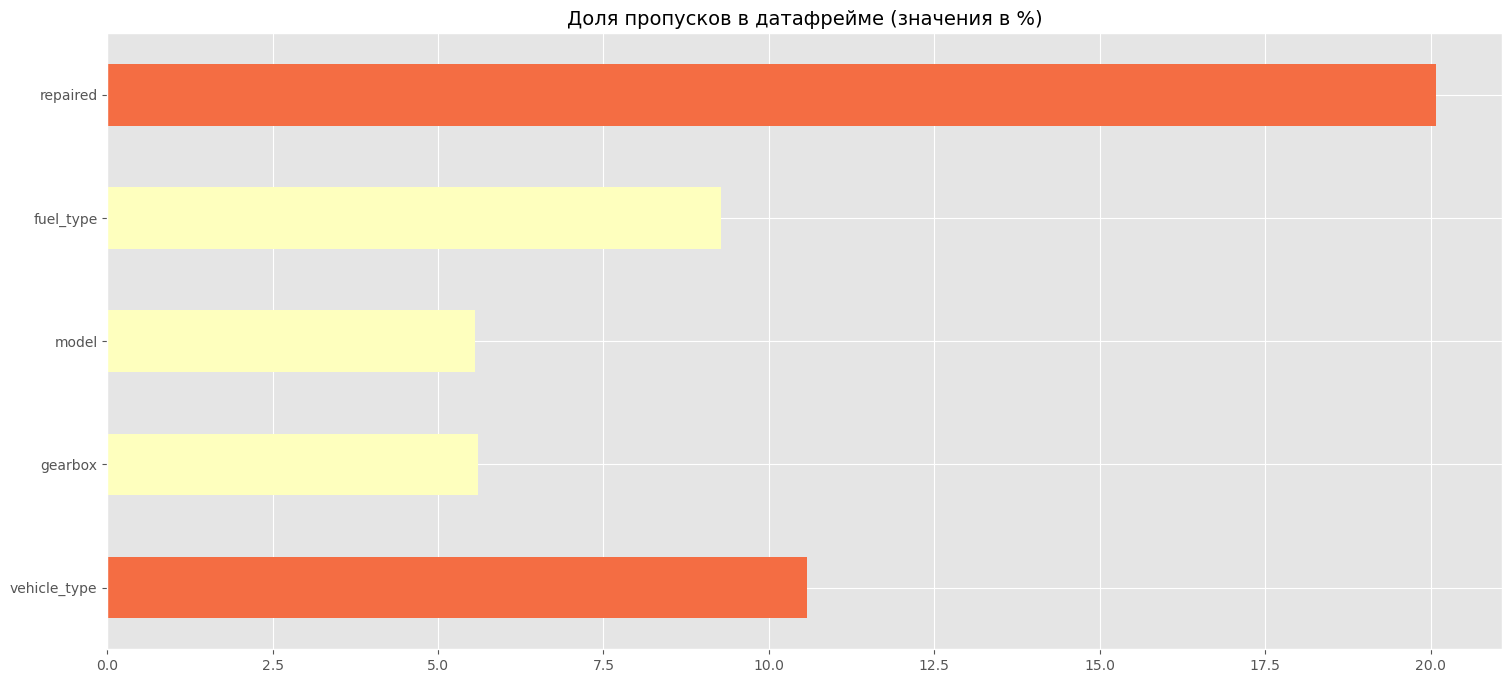

CPU times: total: 109 ms
Wall time: 440 ms


In [16]:
%%time
full_info(df)

**На основе предоставленных данных можно сделать следующие выводы:**

1. В датасете представлено 354369 записей с 16 столбцами. Так же в данных присутствуют 4 дубликата.

2. В столбцах "vehicle_type", "gearbox", "model", "fuel_type" и "repaired" содержатся пропуски в данных:

- "vehicle_type" имеет 37490 пропусков (10.58% пропусков);
- "gearbox" имеет 19833 пропусков (5.60% пропусков);
- "model" имеет 19705 пропусков (5.56% пропусков);
- "fuel_type" имеет 32895 пропусков (9.28% пропусков);
- "repaired" имеет 71154 пропусков (20.08% пропусков).

3. Среди числовых данных:

- Средняя цена ("price") составляет 4416.66, со стандартным отклонением 4514.16. Минимальное значение - 0, максимальное - 20000.
    (Машина в дар это конечно хорошо, но скорее всего имеет место ошибка при заполнении. Возможно два пути решения, удалить или расчитать) 
- Мощность ("power") автомобилей в среднем равна 110.09, со стандартным отклонением 189.85. Минимальное значение - 0, максимальное - 20000. (минимальное значение 0, говорит об ошибке при заполнении, эту информацию можно скорректировать информацию по сопутствующим признакам, и похоже в списке есть Ракета!)
- Пробег ("kilometer") автомобилей в среднем составляет 128211.17 км, со стандартным отклонением 37905.34. Минимальный пробег - 5000 км, максимальный - 150000 км.

4. Явные ошибки:
- Столбец "number_of_pictures", содержит только нулевые значения, что может указывать на некорректно заполненную информацию.
- Столбцы "price", "power", "registration_month" содержат нулевые значения
- Столбец "registration_year", встречается минимальное значение 1000, что явно некорректно, столбец требует дополнительного разбора.

Проверим распределение уникальных значений по столбцам "registration_year", "registration_month" и по столбцам с пропусками "vehicle_type", "gearbox", "model", "fuel_type", "repaired". А так же распределение по столбцам "price", "power" 

In [17]:
#Подготовим список полей для функции
fu_list = ["registration_year", "registration_month", "vehicle_type", "gearbox", "model", "fuel_type", "repaired"]

In [18]:
#напишем функциию "наглядного распределения"
#def fu_pie(df, fu_list):
#    for field in fu_list:
#        if field not in df.columns:
#            print(f"Поле '{field}' отсутствует в датасете.")
#        else:
#            counts = df[field].value_counts()

#           plt.figure(figsize=(16, 10))
#            plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
#            plt.title(f'Distribution of {field}')
#            plt.show()

#            print(f"{field} distribution:")
#            print(counts)
#            print()

In [19]:
# Функция для создания пирогового графика с распределением значений и таблицей
def fu_pie(df, fu_list):
    for field in fu_list:
        if field not in df.columns:
            print(f"Поле '{field}' отсутствует в датасете.")
        else:
            counts = df[field].value_counts()

            # Создаем фигуру с двумя подграфиками
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            
            # Пироговый график
            ax1.pie(counts, labels=counts.index, autopct='%1.1f%%')
            ax1.set_title(f'Distribution of {field}')

            # Табличный вывод значений
            ax2.axis('off')
            table_data = pd.DataFrame(counts).reset_index()
            table_data.columns = [field, 'count']
            ax2.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
            
            plt.show();

            print(f"{field} distribution:")
            #print(counts)
            print()

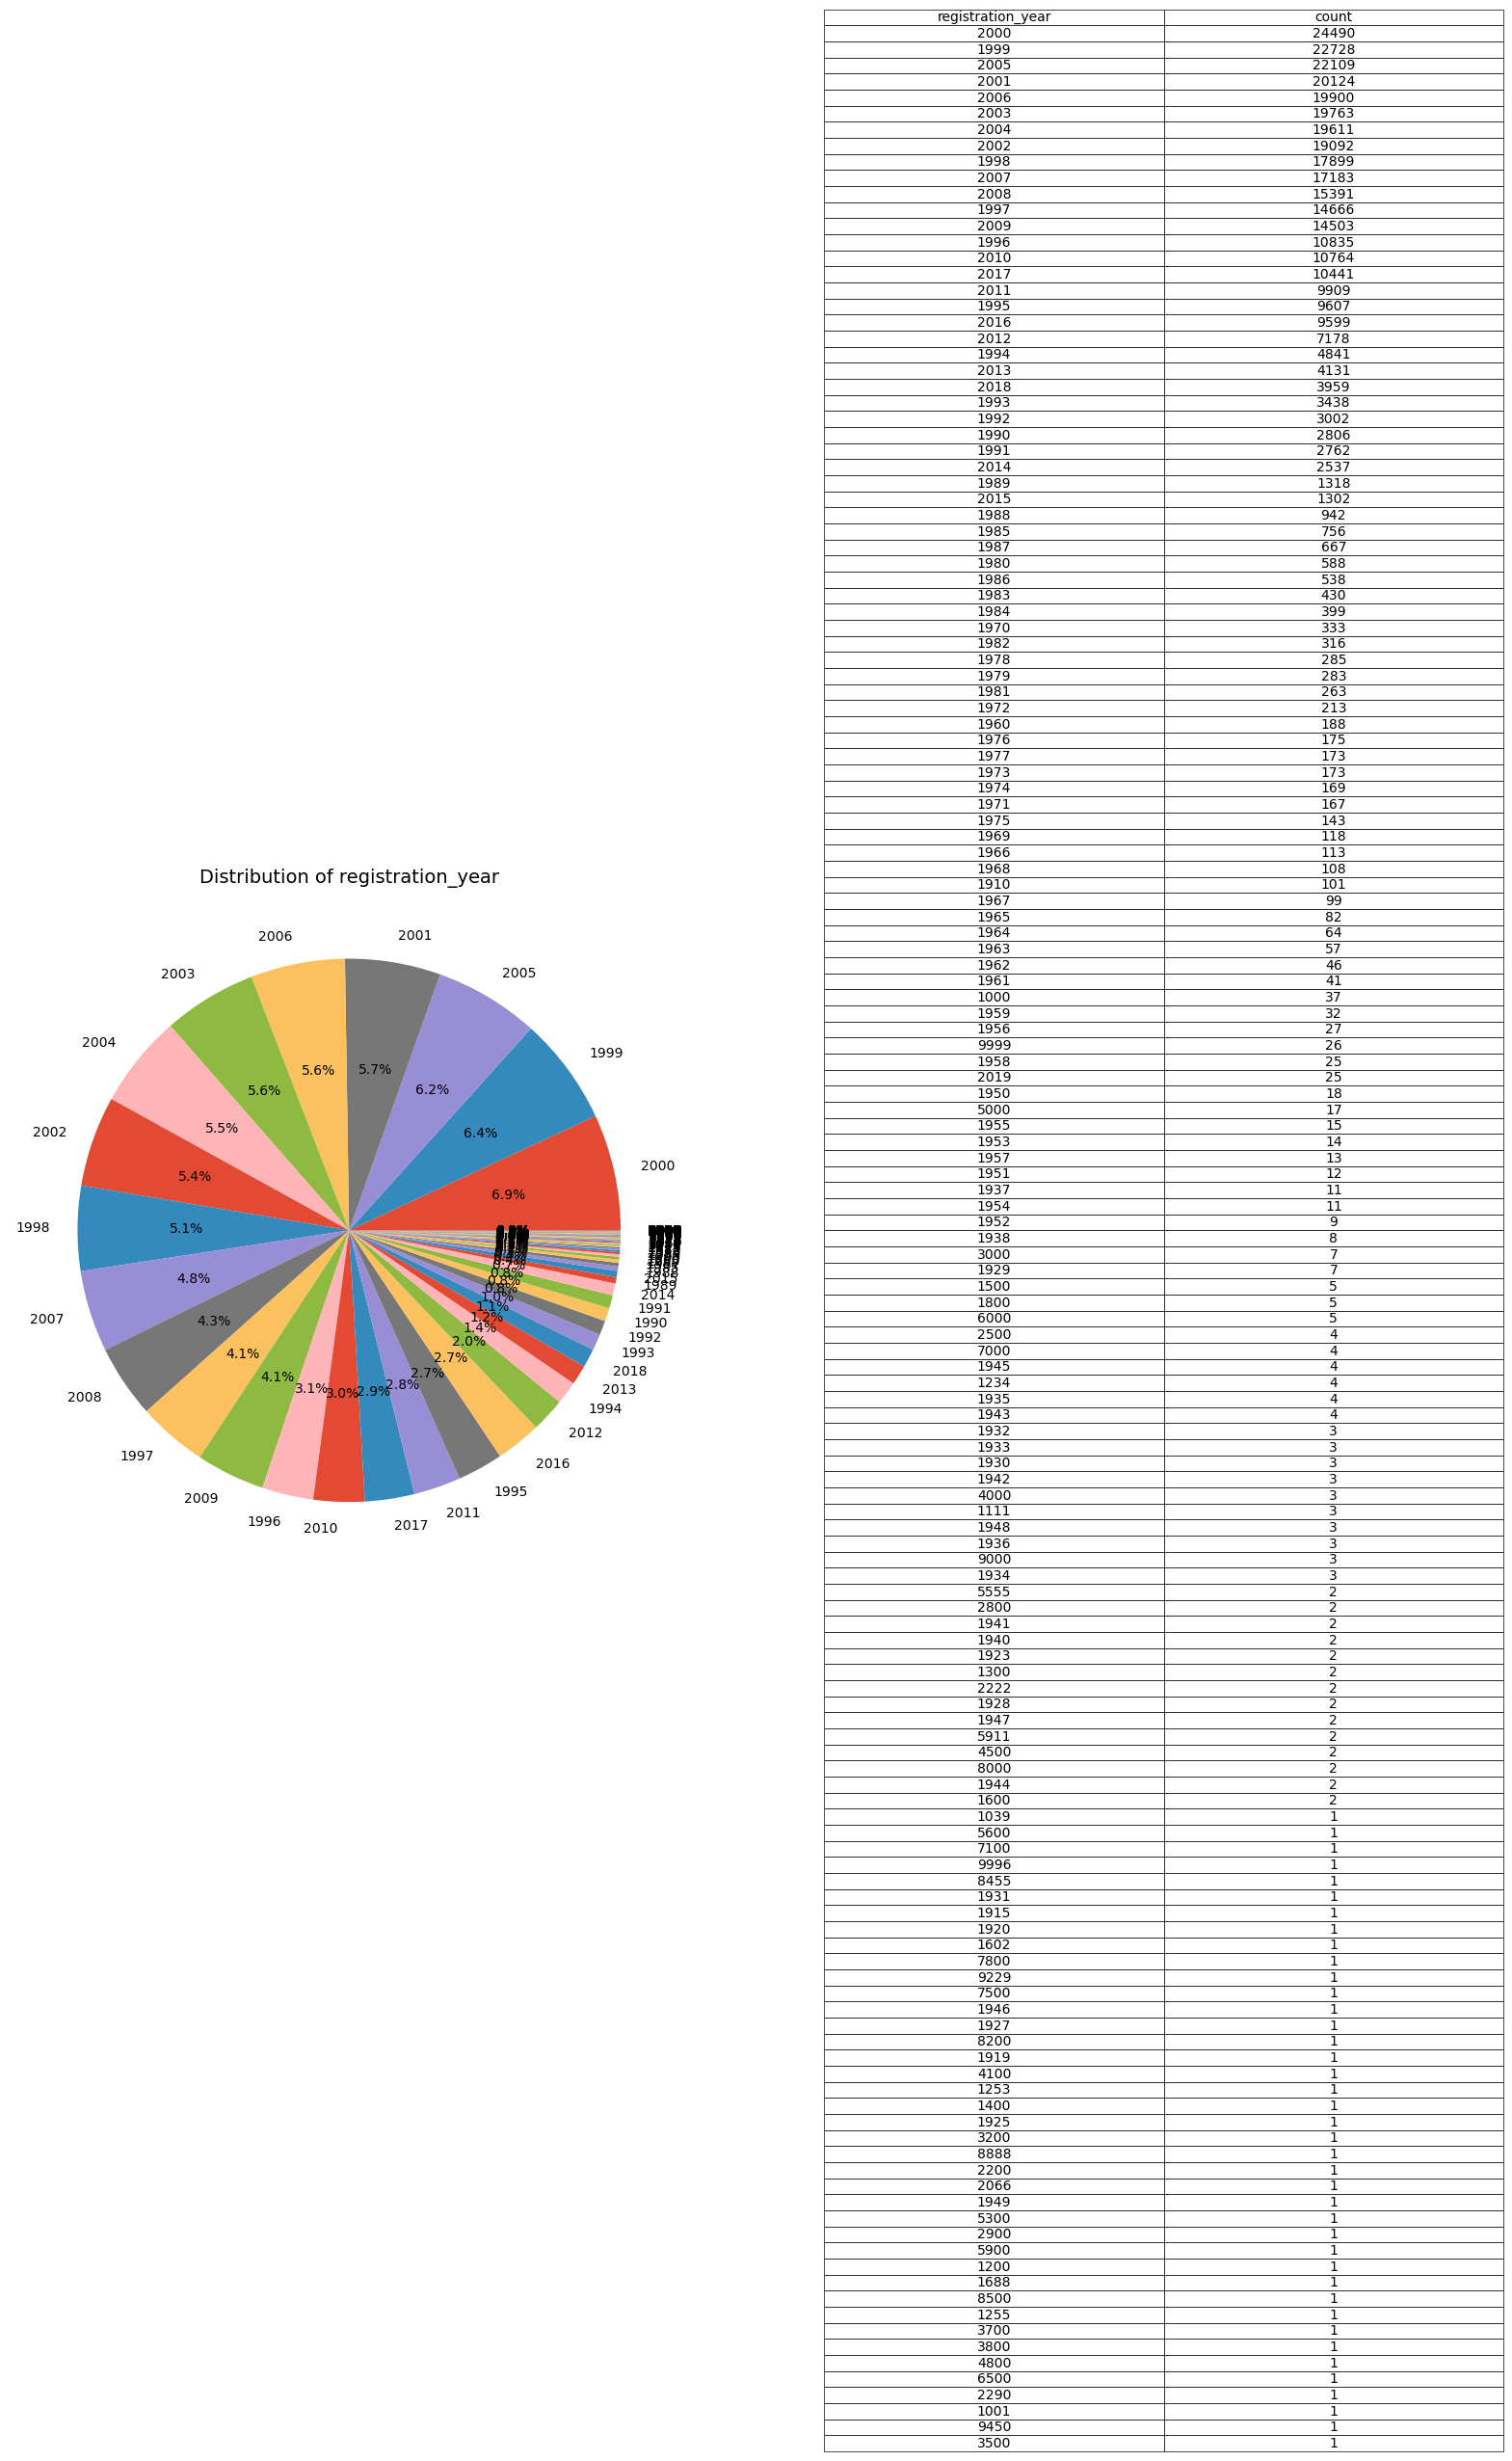

registration_year distribution:



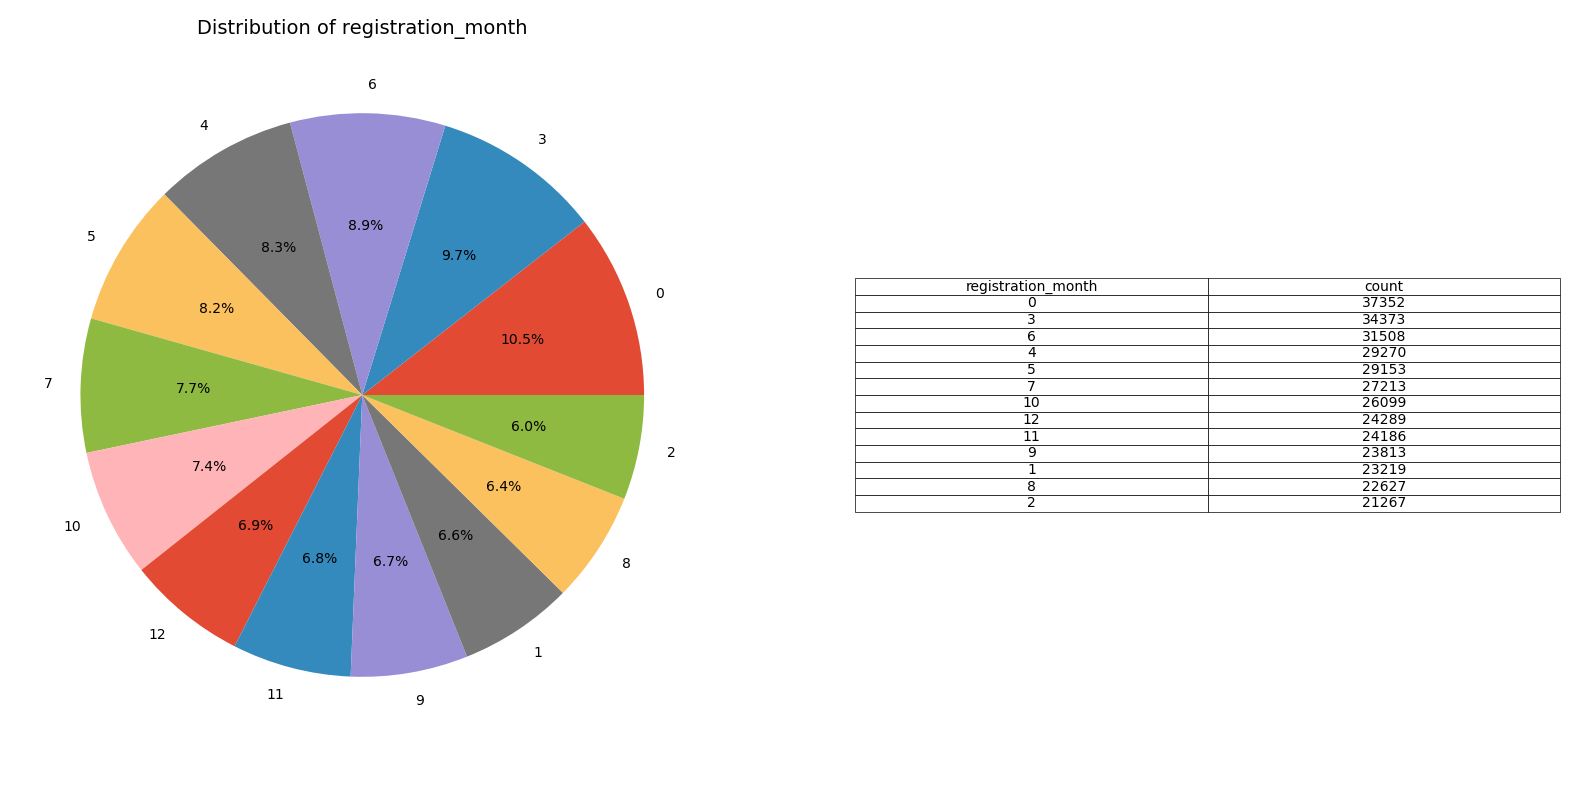

registration_month distribution:



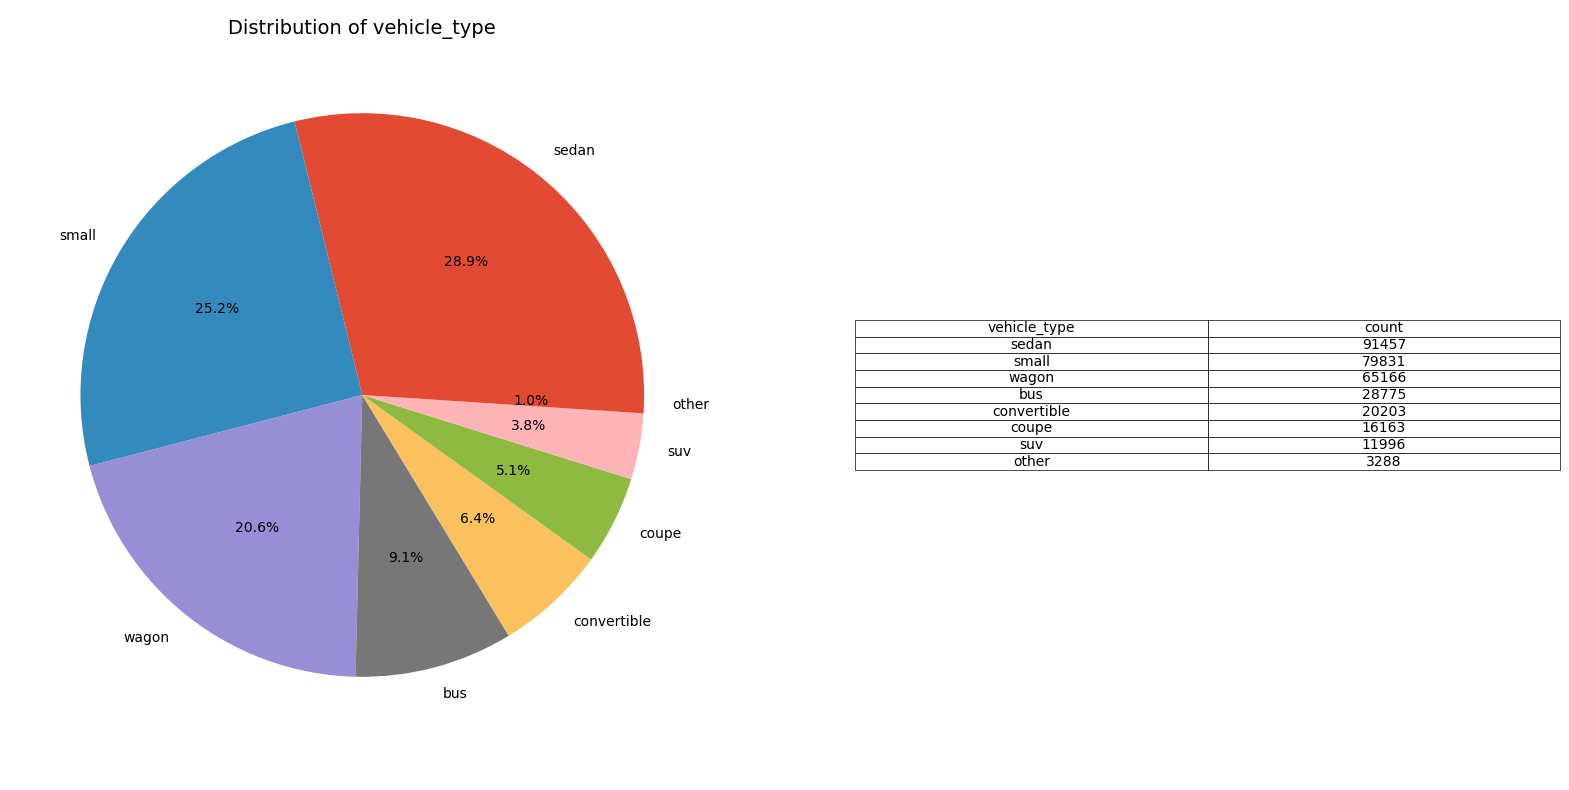

vehicle_type distribution:



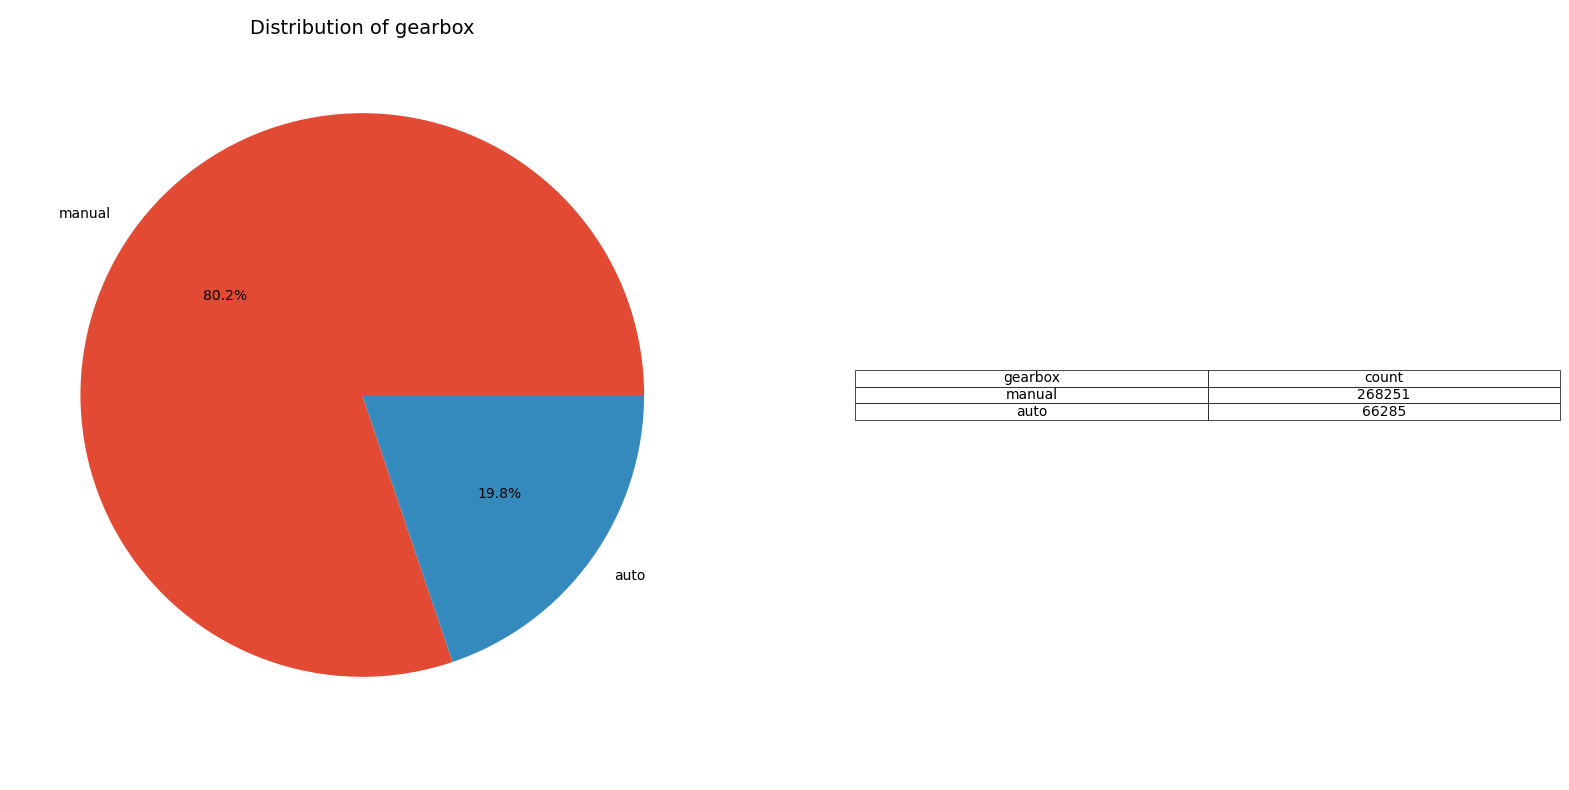

gearbox distribution:



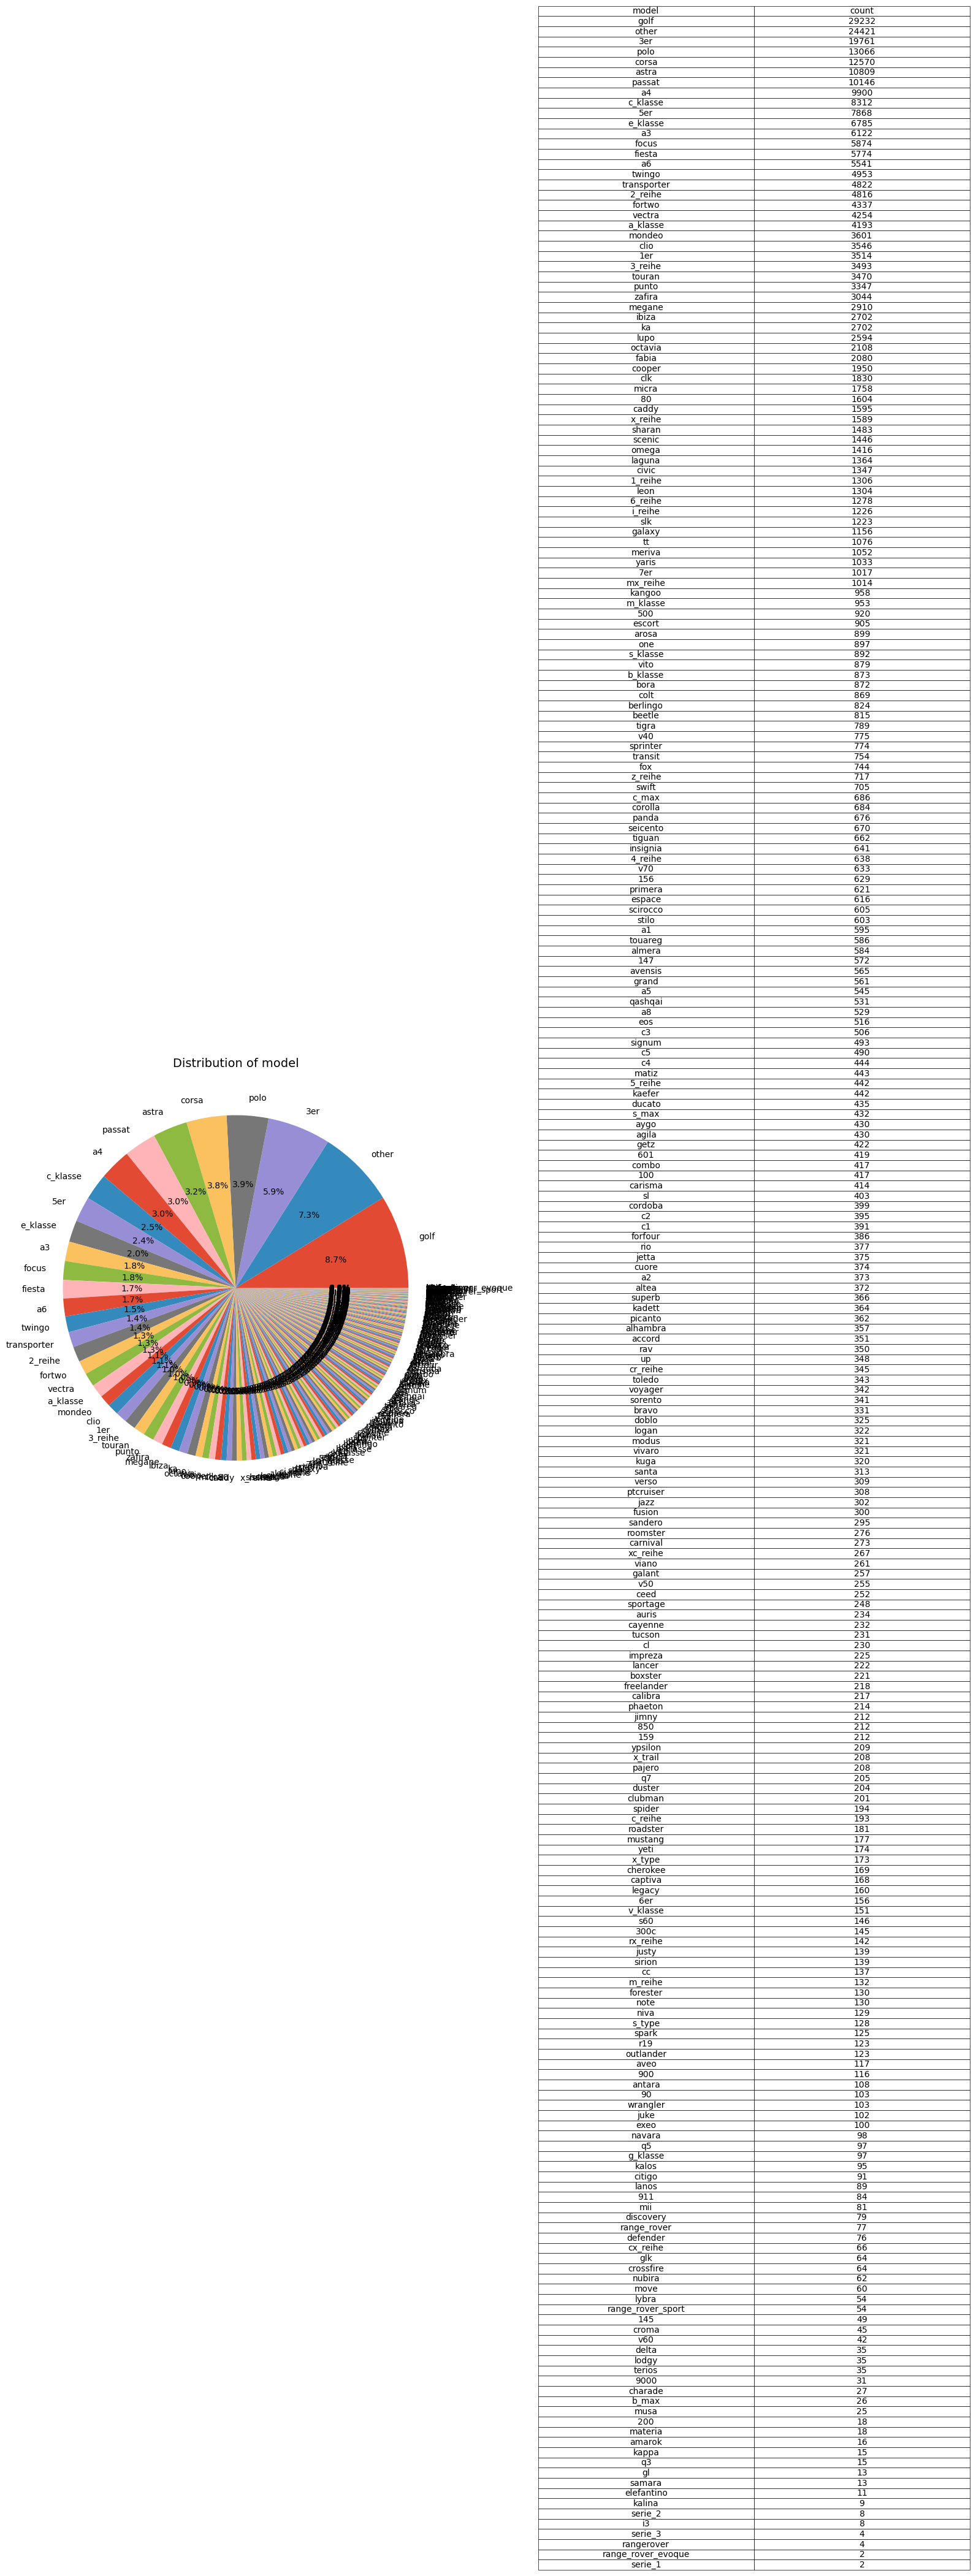

model distribution:



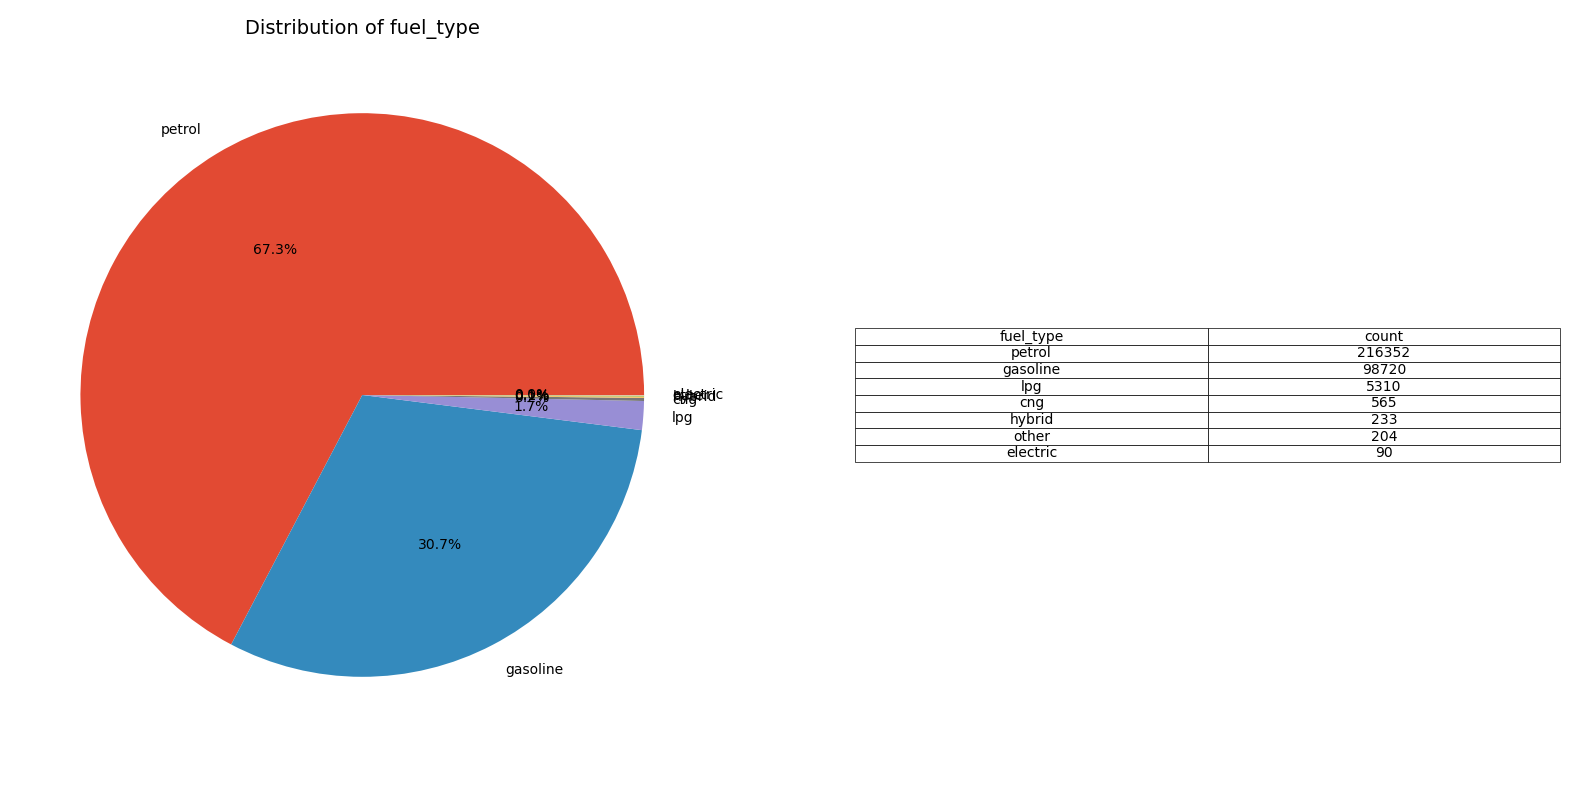

fuel_type distribution:



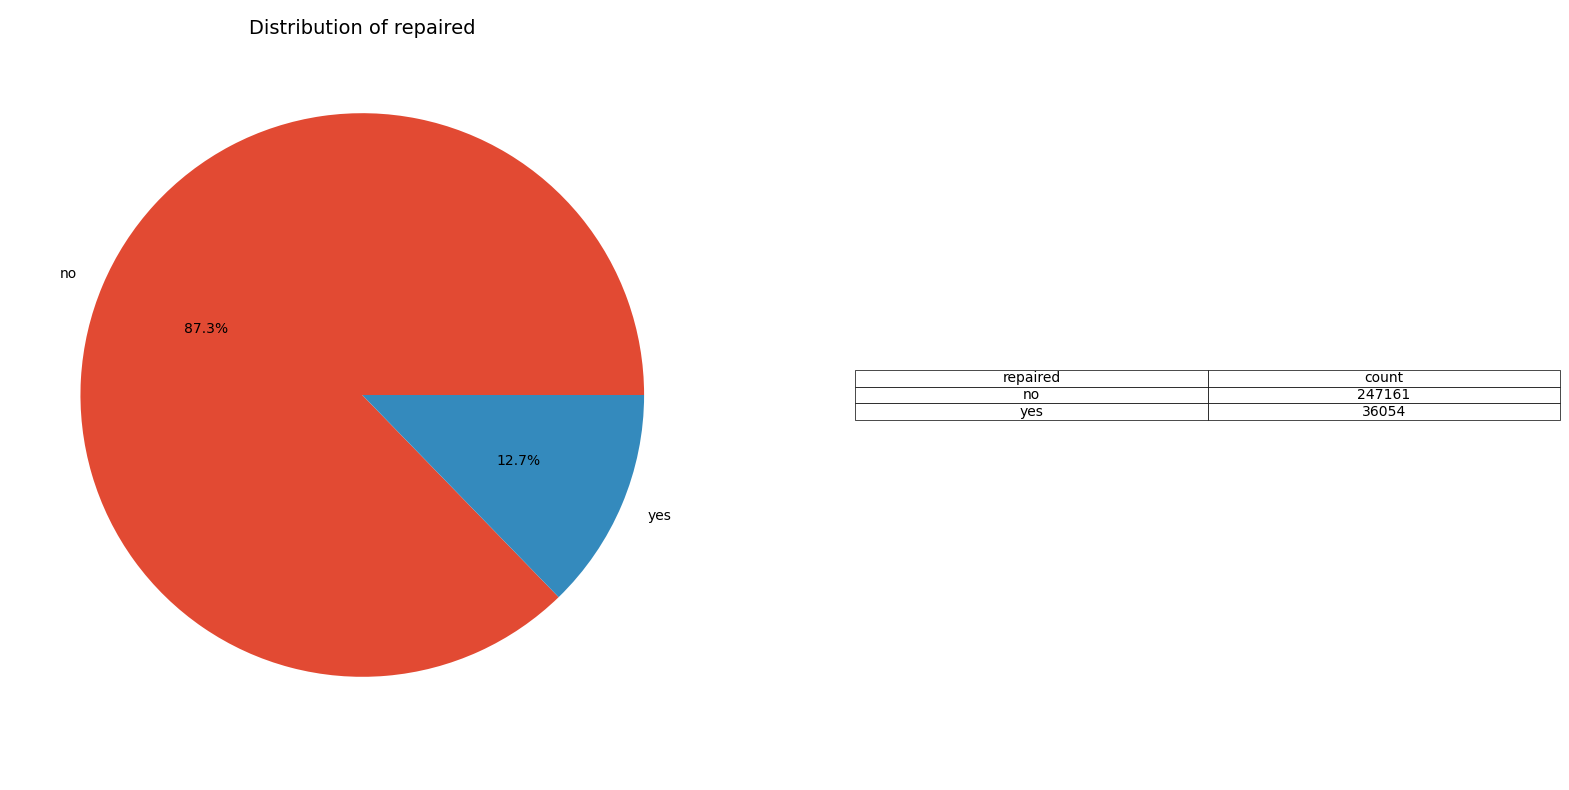

repaired distribution:

CPU times: total: 1.69 s
Wall time: 4.47 s


In [20]:
%%time
fu_pie(df, fu_list)

Посмотрим года регистрации авто на графике

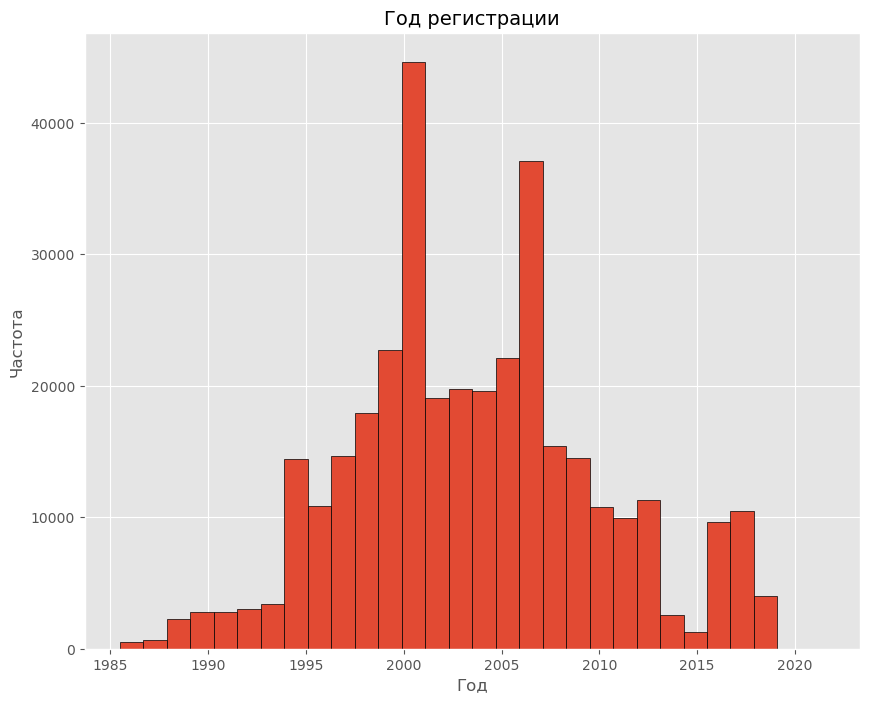

Первый квартиль (Q1): 1999.0
Третий квартиль (Q3): 2008.0
Межквартильный размах (IQR): 9.0


In [21]:
#график распределения по годам и месяцам регистрации
# Рассчитаем Q1, Q3 и IQR для года регистрации
q1 = df['registration_year'].quantile(0.25)  # первый квартиль Q1
q3 = df['registration_year'].quantile(0.75)  # третий квартиль Q3
iqr = q3 - q1  # межквартильный размах IQR

# Построим гистограмму года регистрации с учетом выбросов
plt.figure(figsize=(10, 8))
df['registration_year'].hist(bins=30, range=((q1 - 1.5 * iqr), (q3 + 1.5 * iqr)), ec='black')
plt.title('Год регистрации')
plt.xlabel('Год')
plt.ylabel('Частота')
plt.show()

# Выведем информацию по квантилям
print(f'Первый квартиль (Q1): {q1}')
print(f'Третий квартиль (Q3): {q3}')
print(f'Межквартильный размах (IQR): {iqr}')

Исходя из графика, данные с регистрацией ТС раньше 1985 года мы можем откинуть, проверим верхний порог по датам объявления.

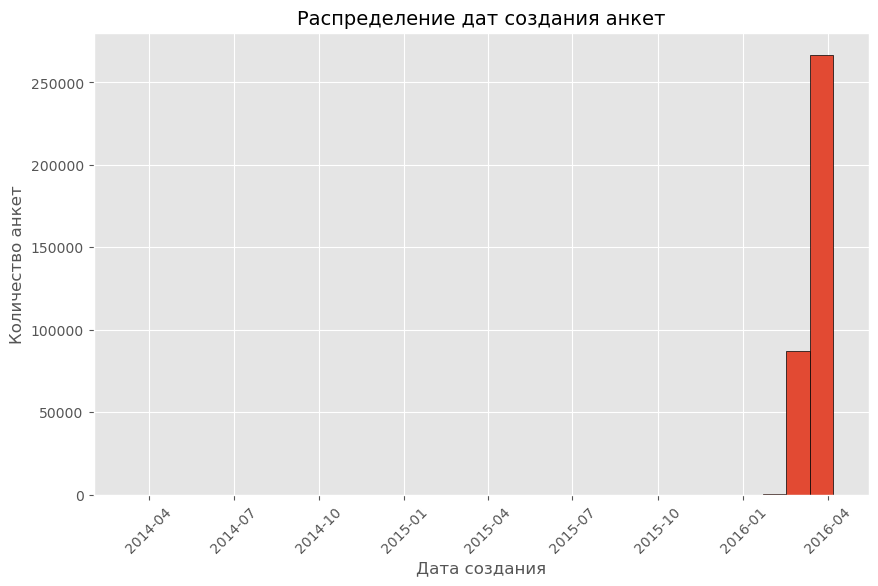

Дата последнего объявления: 2016-04-07 00:00:00


In [22]:
#Построим график по полю 'date_created'
plt.figure(figsize=(10, 6))
df['date_created'].hist(bins=30, edgecolor='black')
plt.title('Распределение дат создания анкет')
plt.xlabel('Дата создания')
plt.ylabel('Количество анкет')
plt.xticks(rotation=45)
plt.show()

# Вывод даты последнего объявления
latest_date = df['date_created'].max()
print(f'Дата последнего объявления: {latest_date}')

Очень странное распределение даты создания анкеты, говорит о запуске проекта, или о полностью искуственных данных. 

In [23]:
df['date_created'].dt.year.value_counts().sort_index()

date_created
2014         1
2015        25
2016    354343
Name: count, dtype: int64

Так как у нас нет возможности уточнения информации, то думаю можно смело удалить данные за 2014 и 2015 года, так же удалим данные по дате регистрации ТС меньше 1985 и больше 2016-04, ну и не забудем нулевой месяц регистрации ТС.

In [24]:
# сохраняем начальный датасет для анализа
df_full = df.copy()

# Условия для удаления аномалий
delete_index = df[((df['date_created'].dt.year < 2016) | 
                   (df['registration_month'] == 0) | 
                   ((df['registration_year'] < 1985) | (df['registration_year'] > 2016) |
                   ((df['registration_year'] == 2016) & (df['registration_month'] > 4))))].index

# Сохраняем удаленные строки в переменной
deleted_rows = df.loc[delete_index]

# Удаляем строки  
df.drop(delete_index, inplace=True)

# Подсчитываем процент удаленных строк от изначального количества
deleted_percent = len(deleted_rows) / len(df_full) * 100

# Выводим информацию о удаленных строках и проценте удаления
print("Удаленные строки:")
print(deleted_rows)
print(f"Процент удаленных строк: {deleted_percent:.2f}%")

# Выводим информацию о новом размере датасета
print("Новый размер датасета после удаления:", df.shape)

Удаленные строки:
       date_crawled  price vehicle_type  registration_year gearbox  power  \
0        2016-03-24    480          NaN               1993  manual      0   
7        2016-03-21      0        sedan               1980  manual     50   
9        2016-03-17    999        small               1998  manual    101   
15       2016-03-11    450        small               1910     NaN      0   
16       2016-04-01    300          NaN               2016     NaN     60   
...             ...    ...          ...                ...     ...    ...   
354318   2016-03-15    400        wagon               1991  manual      0   
354326   2016-03-31   1300        small               1999  manual     75   
354329   2016-03-30    350        small               1996     NaN     65   
354337   2016-03-26  11500        sedan               2004    auto    445   
354361   2016-03-09   5250          NaN               2016    auto    150   

          model  kilometer  registration_month fuel_type 

Название датафрейма: Автопродажи 

<class 'pandas.core.frame.DataFrame'>
Index: 297235 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        297235 non-null  datetime64[ns]
 1   price               297235 non-null  int64         
 2   vehicle_type        290343 non-null  object        
 3   registration_year   297235 non-null  int64         
 4   gearbox             288981 non-null  object        
 5   power               297235 non-null  int64         
 6   model               286864 non-null  object        
 7   kilometer           297235 non-null  int64         
 8   registration_month  297235 non-null  int64         
 9   fuel_type           284546 non-null  object        
 10  brand               297235 non-null  object        
 11  repaired            255127 non-null  object        
 12  date_created        297235 non-null  datetime64[ns]
 13 

None

count                           mean  \
date_crawled           297235  2016-03-20 20:52:19.382643200   
price              297,235.00                       4,764.20   
registration_year  297,235.00                       2,002.98   
power              297,235.00                         116.33   
kilometer          297,235.00                     128,448.63   
registration_month 297,235.00                           6.37   
date_created           297235  2016-03-20 19:01:38.818779648   
number_of_pictures 297,235.00                           0.00   
postal_code        297,235.00                      51,003.07   
last_seen              297235  2016-03-29 13:35:19.547160064   

                                    min                  25%  \
date_crawled        2016-03-05 00:00:00  2016-03-13 00:00:00   
price                              0.00             1,299.00   
registration_year              1,985.00             1,999.00   
power                              0.00                75.00   
kilometer                      5,000.00           125,000.00   
registration_month                 1.00                 3.00   
date_created        2016-01-02 00:00:00  2016-03-13 00:00:00   
number_of_pictures                 0.00                 0.00   
postal_code                    1,067.00            30,826.00   
last_seen           2016-03-05 00:00:00  2016-03-23 00:00:00   

                                    50%                  75%  \
date_crawled        2016-03-21 00:00:00  2016-03-29 00:00:00   
price                          3,000.00             6,900.00   
registration_year              2,003.00             2,007.00   
power                            109.00               145.00   
kilometer                    150,000.00           150,000.00   
registration_month                 6.00                 9.00   
date_created        2016-03-21 00:00:00  2016-03-29 00:00:00   
number_of_pictures                 0.00                 0.00   
postal_code                   49,832.00            71,636.00   
last_seen           2016-04-03 00:00:00  2016-04-06 00:00:00   

                                    max       std  
date_crawled        2016-04-07 00:00:00       NaN  
price                         20,000.00  4,604.04  
registration_year              2,016.00      5.55  
power                         20,000.00    175.25  
kilometer                    150,000.00 36,692.28  
registration_month                12.00      3.36  
date_created        2016-04-07 00:00:00       NaN  
number_of_pictures                 0.00      0.00  
postal_code                   99,998.00 25,742.49  
last_seen           2016-04-07 00:00:00       NaN

date_crawled  price vehicle_type  registration_year gearbox  power  \
174843   2016-03-28  10900          bus               1989  manual     95   
198482   2016-03-26   1200        small               2000  manual     60   
28768    2016-03-25    850        small               1996  manual     73   
196321   2016-03-11   6250        sedan               1988  manual    129   
93670    2016-03-17    965        small               1999  manual     60   

              model  kilometer  registration_month fuel_type       brand  \
174843  transporter     150000                   5    petrol  volkswagen   
198482       twingo     150000                   8    petrol     renault   
28768           NaN     125000                   8    petrol       mazda   
196321         golf     150000                  10    petrol  volkswagen   
93670          polo     150000                  11    petrol  volkswagen   

       repaired date_created  number_of_pictures  postal_code  last_seen  
174843       no   2016-03-28                   0        84478 2016-04-06  
198482       no   2016-03-26                   0         6917 2016-04-06  
28768       yes   2016-03-25                   0        53809 2016-04-06  
196321       no   2016-03-11                   0        65207 2016-03-25  
93670        no   2016-03-17                   0        63179 2016-04-07

Количество дубликатов в данных: 6214
Количество столбцов: 16, число записей: 297235

Столбец "vehicle_type" содержит 6892 пропусков (2.32% пропусков)
Столбец "gearbox" содержит 8254 пропусков (2.78% пропусков)
Столбец "model" содержит 10371 пропусков (3.49% пропусков)
Столбец "fuel_type" содержит 12689 пропусков (4.27% пропусков)
Столбец "repaired" содержит 42108 пропусков (14.17% пропусков)


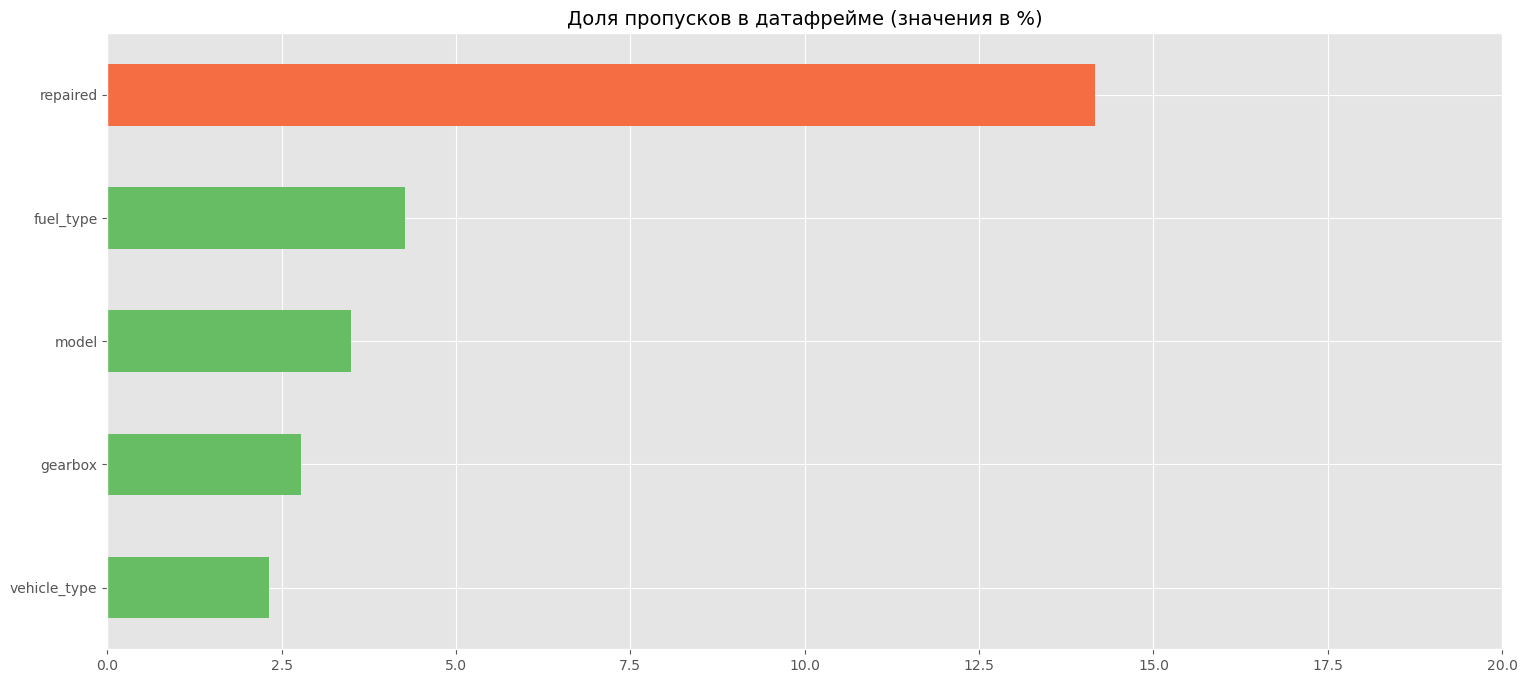

In [25]:
full_info(df)

In [26]:
df['registration_year'].value_counts().sort_index()

registration_year
1985      501
1986      456
1987      565
1988      808
1989     1103
1990     1876
1991     2356
1992     2591
1993     2875
1994     4102
1995     7298
1996     9211
1997    12623
1998    15635
1999    20301
2000    19619
2001    18424
2002    17849
2003    18637
2004    18676
2005    19881
2006    19083
2007    16612
2008    14893
2009    14104
2010    10531
2011     9746
2012     7072
2013     4056
2014     2490
2015     1105
2016     2156
Name: count, dtype: int64

В доске объявлений о продаже автомобилей термин "repaired" (восстановлен) обычно указывает на то, что автомобиль был в ремонте или восстановлении. Это может означать, что автомобиль был подвергнут ремонту после аварии, столкновения или других повреждений.

В поле "repaired", содержится 42108 пропусков (14.17% пропусков), что является довольно большим процентом от общих данных и требует корректировки, удаление такого объема не желательно по этому я вижу два возможных варианта.

1. Проставление значения "yes" или "no". 
2. Добавление третьей категории, например, "unknown" или "missing"

Определить, был ли автомобиль поврежден или нет, по параметрам объявления можно, например по "цене", "фото" или "истории ТС". Но в нашем случае "фото" и "истории ТС" нет. По этому остаётся прогноз из цены ТС или второй вариант.

Цена автомобиля может быть одним из показателей, позволяющих предположить о наличии повреждений. Низкая цена по сравнению с аналогичными моделями на рынке может свидетельствовать о том, что автомобиль имеет скрытые повреждения или проблемы, которые снижают его стоимость. Например, если цена значительно ниже среднего рыночного уровня для данной модели и года выпуска, это может быть признаком наличия серьезных повреждений, которые не упомянуты в объявлении.

Однако стоит помнить, что низкая цена не всегда обязательно указывает на повреждения. Продавец может просто желать быстро продать автомобиль или у него могут быть другие причины для установки более низкой цены. Поэтому при оценке состояния автомобиля по цене следует учитывать и другие факторы, которые в нашем случае отсутствуют. По этому я предпочту второй вариант и добавлю третью категорию "unknown".

In [27]:
# Заменяем пропущенные значения в столбце 'repaired' на 'unknown'
df['repaired'].fillna(value='unknown', inplace=True)

In [28]:
# Проверка столбца на пустые значения
df['repaired'].isnull().sum()

0

Посмотрим остальные поля содержащие пропуски. 
- "vehicle_type" содержит 6892 пропусков (2.32% пропусков)
- "gearbox" содержит 8254 пропусков (2.78% пропусков)
- "model" содержит 10371 пропусков (3.49% пропусков)
- "fuel_type" содержит 12689 пропусков (4.27% пропусков)

In [29]:
# Посмотрим распределение по типу кузова
display(df['vehicle_type']
        .value_counts(dropna=False)
        .to_frame()
        .reset_index()
        .rename(columns = {'vehicle_type':'кол-во', 'index':'Тип кузова'}))

кол-во  count
0        sedan  84219
1        small  72595
2        wagon  60268
3          bus  27141
4  convertible  18410
5        coupe  13971
6          suv  11165
7          NaN   6892
8        other   2574

Из получившейся картинки мы видим
- Седан (sedan) - самый распространенный тип кузова с 84219 автомобилей.
- Малолитражный автомобиль (small) - второе место после седана имеет 72595 представленных автомобилей.
- Универсал (wagon) - занимает третье место с 60268 автомобилей.

- Универсал с повышенным клиренсом (suv) - отмечается как менее распространенный тип кузова с 11165 автомобилей.

Также в данных присутствуют следующие типы кузовов со своими количествами:

- Минивэн(автобус) (bus) - 27141 автомобиль
- Кабриолет (convertible) - 18410 автомобилей
- Купе (coupe) - 13971 автомобиль
- Другой (other) - 2574 автомобиля

И пропущенные значения: 
- Пропуски (NaN) - 6892 автомобиля

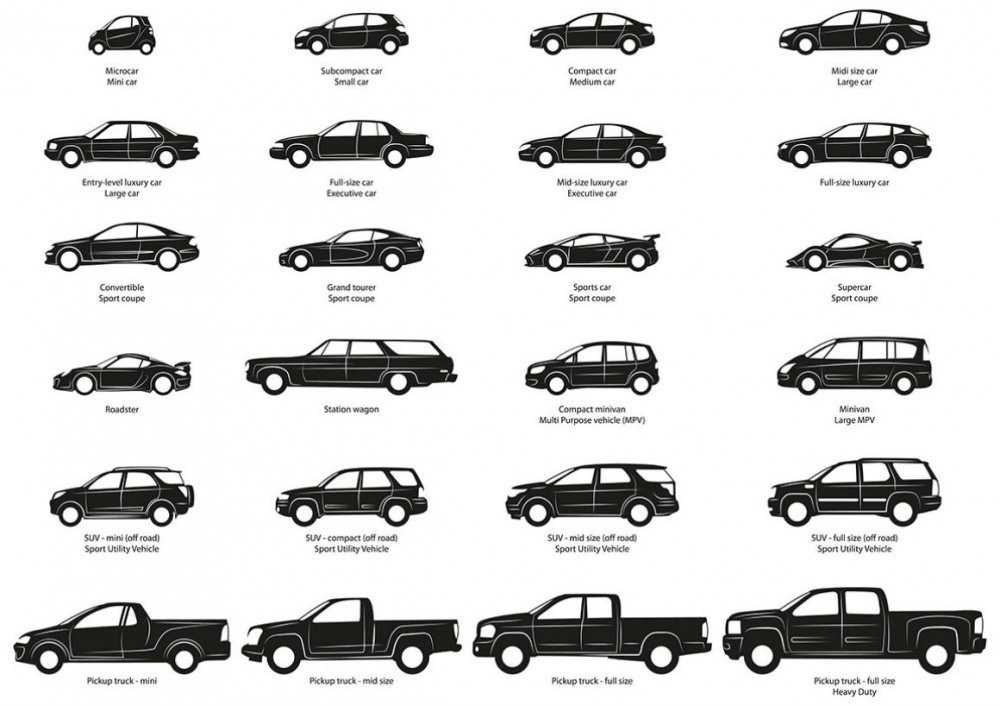

Для исправления пропусков в столбце "vehicle_type", можно использовать следующий подход:
1. Создать словарь, который будет содержать сочетания "brand + model + registration_year" в качестве ключей и наиболее часто встречающийся тип кузова для каждого сочетания в качестве значения.
2. Пройти по строкам с пропущенными значениями в столбце "vehicle_type" и заполнить их типом кузова, соответствующим сочетанию "brand + model + registration_year" из созданного словаря.
3. Для оставшихся пропущенных значений можно присвоить тип кузова "other" или удалить такие строки из набора данных в зависимости от количества и значения данных пропусков.

Но так как "model" также имеет пропущенные значения, то следует проверить распределение и выявить наиболее часто встречающиеся модели для каждого бренда.

In [30]:
%%time
# Создадим словарь для хранения типа кузова на стыке бренда и модели
brand_model_vehicle_type = {}

# Заполним словарь значениями
for index, row in df.iterrows():
    brand_model_key = (row['brand'], row['model'])
    brand_model_vehicle_type[brand_model_key] = row['vehicle_type']

# Создадим DataFrame на основе словаря
df_brand_model_vehicle_type = pd.DataFrame(brand_model_vehicle_type.items(), columns=['brand_model', 'vehicle_type'])
df_brand_model_vehicle_type[['brand', 'model']] = pd.DataFrame(df_brand_model_vehicle_type['brand_model'].tolist(), index=df_brand_model_vehicle_type.index)

# Отсортируем DataFrame по столбцам 'brand' и 'model'
df_sorted = df_brand_model_vehicle_type.sort_values(by=['brand', 'model'])

# Выведем информацию о типе кузова на стыке бренда и модели
pd.set_option('display.max_rows', None)
display(df_sorted[['brand', 'model', 'vehicle_type']]
        .rename(columns = {'brand':'Бренд', 'model':'Модель', 'vehicle_type':'Тип кузова'}))

Бренд              Модель   Тип кузова
305      alfa_romeo                 145        small
57       alfa_romeo                 147        coupe
213      alfa_romeo                 156        sedan
150      alfa_romeo                 159        wagon
179      alfa_romeo               other        coupe
115      alfa_romeo              spider  convertible
111      alfa_romeo                 NaN        wagon
58             audi                 100        sedan
309            audi                 200        sedan
56             audi                  80        sedan
184            audi                  90        sedan
46             audi                  a1        small
122            audi                  a2        small
72             audi                  a3        sedan
45             audi                  a4        wagon
138            audi                  a5        coupe
51             audi                  a6        wagon
30             audi                  a8        sedan
156            audi               other  convertible
283            audi                  q3        sedan
318            audi                  q5        sedan
245            audi                  q7        sedan
50             audi                  tt        coupe
0              audi                 NaN        sedan
25              bmw                 1er        sedan
4               bmw                 3er        wagon
13              bmw                 5er        sedan
304             bmw                 6er        coupe
55              bmw                 7er        sedan
327             bmw                  i3        sedan
209             bmw             m_reihe        coupe
149             bmw               other        coupe
153             bmw             x_reihe        sedan
62              bmw             z_reihe  convertible
90              bmw                 NaN          NaN
312       chevrolet                aveo        sedan
247       chevrolet             captiva          suv
105       chevrolet               matiz        small
97        chevrolet               other        small
217       chevrolet               spark        small
310       chevrolet                 NaN        small
214        chrysler                300c        wagon
187        chrysler           crossfire        coupe
230        chrysler               grand          bus
140        chrysler               other        sedan
141        chrysler           ptcruiser        sedan
231        chrysler             voyager          bus
281        chrysler                 NaN        sedan
84          citroen            berlingo          bus
238         citroen                  c1        small
265         citroen                  c2        small
124         citroen                  c3        small
89          citroen                  c4          bus
198         citroen                  c5        sedan
117         citroen               other        wagon
210         citroen                 NaN        coupe
190           dacia              duster          suv
277           dacia               lodgy          bus
112           dacia               logan        wagon
307           dacia               other        wagon
252           dacia             sandero        small
299           dacia                 NaN        small
171          daewoo               kalos        sedan
271          daewoo               lanos        sedan
182          daewoo               matiz        small
269          daewoo              nubira        wagon
259          daewoo               other          bus
323          daewoo                 NaN        sedan
289        daihatsu             charade        small
118        daihatsu               cuore        small
320        daihatsu             materia        wagon
298        daihatsu                move        small
288        daihatsu               other          bus
185        daihatsu              sirion        small
314        daihatsu              terios

CPU times: total: 8.75 s
Wall time: 20.6 s


Всё выглядет несколько печальней чем я думал, при должном количестве времени и внешних базах можно было бы определеить большую часть пропусков в моделях, но сейчас посмотрим на масштаб проблемы дополнив параметры registration_year, gearbox, power для анализа.

In [31]:
# Посмотрим распределение  
pd.set_option('display.max_rows', 30)
display(df.groupby(['brand', 'model', 'vehicle_type', 'registration_year', 'gearbox', 'power']).size().reset_index(name='count'))

brand     model vehicle_type  registration_year gearbox  power  \
0      alfa_romeo       145        coupe               1999  manual      0   
1      alfa_romeo       145        coupe               1999  manual    103   
2      alfa_romeo       145        other               1995  manual    100   
3      alfa_romeo       145        sedan               1995  manual     90   
4      alfa_romeo       145        sedan               1997  manual    140   
...           ...       ...          ...                ...     ...    ...   
55518       volvo  xc_reihe        wagon               2008    auto    185   
55519       volvo  xc_reihe        wagon               2009    auto    185   
55520       volvo  xc_reihe        wagon               2009    auto    205   
55521       volvo  xc_reihe        wagon               2010    auto    163   
55522       volvo  xc_reihe        wagon               2011  manual    163   

       count  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
55518      6  
55519      2  
55520      2  
55521      2  
55522      2  

[55523 rows x 7 columns]


Глядя на распределение, вижу следующие проблемы, некоректные значения в поле power, явные ошибки при выборе типа кузова.     
Как пример, посмотрим Alfa Romeo 145 - это семейство моделей с кузовом 3-дверный хэтчбек, C-класса, передний привод.   
Механика. Бензиновые и дизельные двигатели мощностью от 103 до 155 лошадиных сил. Годы производства: 1994–2001.  
  
С 09.1994 по 03.1999 выпускался с двигателями:

|Модификации|Объем двигателя, см³|Марка двигателя|
|:----------|--------------------|---------------|
|1.4 л, 90 л.с., бензин, МКПП, передний привод |1351	|AR 33501|
|1.4 л, 103 л.с., бензин, МКПП, передний привод |1370	|AR 33503|
|1.6 л, 103 л.с., бензин, МКПП, передний привод |1596	|AR 33201|
|1.6 л, 120 л.с., бензин, МКПП, передний привод	|1598	|AR 38201|
|1.7 л, 129 л.с., бензин, МКПП, передний привод	|1712	|AR 33401|
|1.7 л, 140 л.с., бензин, МКПП, передний привод	|1747	|AR 38401|
|1.9 л, 90 л.с., дизель, МКПП, передний привод |1929	|AR 33601|
|2.0 л, 150 л.с., бензин, МКПП, передний привод	|1970	|AR 67204|
    
С 04.1999 по 2001 выпускался с двигателями:

|Модификации|Объем двигателя, см³|Марка двигателя|
|-----------|--------------------|---------------|
|1.4 л, 103 л.с., бензин, МКПП, передний привод	|1370	|AR 33503|
|1.6 л, 120 л.с., бензин, МКПП, передний привод	|1598	|AR 38201|
|1.7 л, 144 л.с., бензин, МКПП, передний привод	|1747	|AR 38401|
|1.9 л, 105 л.с., дизель, МКПП, передний привод	|1910	|AR 32302|
|2.0 л, 155 л.с., бензин, МКПП, передний привод	|1970	|AR 67204|


In [32]:
%%time
# Создание словаря для хранения характеристик
brand_model_vehicle_dict = {}

for index, row in df.iterrows():
    brand_model_key = (
        row['brand'], 
        row['model'], 
        row['power'], 
        row['gearbox'], 
        row['fuel_type'], 
        row['registration_year']
    )
    brand_model_vehicle_dict[brand_model_key] = {
        'vehicle_type': row['vehicle_type'],
        'gearbox': row['gearbox'],
        'fuel_type': row['fuel_type'],
        'registration_year': row['registration_year']
    }

# Создание DataFrame autos на основе словаря
autos = pd.DataFrame([
    {'brand': k[0], 'model': k[1], 'power': k[2], 'gearbox': k[3], 'fuel_type': k[4], **v} 
    for k, v in brand_model_vehicle_dict.items()
])

# Сортировка DataFrame по столбцам 'brand' и 'model'
autos.sort_values(by=['brand', 'model'], inplace=True)

# Вывод первых нескольких строк для проверки
display(autos.head())

brand model  power gearbox fuel_type vehicle_type  \
6579   alfa_romeo   145    140  manual    petrol        small   
8328   alfa_romeo   145    103  manual    petrol        small   
9563   alfa_romeo   145      0  manual    petrol        small   
9738   alfa_romeo   145    120  manual    petrol        sedan   
11425  alfa_romeo   145    103  manual    petrol        small   

       registration_year  
6579                1998  
8328                1999  
9563                1997  
9738                1999  
11425               1996

CPU times: total: 12.4 s
Wall time: 26.5 s


In [33]:
def restore_missing_values(df, autos):
    def restore_value(row, autos, column, conditions):
        try:
            source = autos
            for condition in conditions:
                source = source[source[condition] == row[condition]]
                
            unique_values = source[column].unique()
            if len(unique_values) == 1:
                return unique_values[0]
            else:
                return None
        except Exception as e:
            print(f"Error restoring {column} for row {row.name}: {e}")
            return None

    # Восстановление значений модели
    df['model'] = df.apply(lambda row: restore_value(row, autos, 'model', ['brand', 'power', 'gearbox', 'fuel_type', 'vehicle_type']) if pd.isna(row['model']) else row['model'], axis=1)

    # Восстановление значений типа кузова
    df['vehicle_type'] = df.apply(lambda row: restore_value(row, autos, 'vehicle_type', ['brand', 'model', 'power', 'gearbox', 'fuel_type']) if pd.isna(row['vehicle_type']) else row['vehicle_type'], axis=1)

    # Восстановление значений типа топлива
    df['fuel_type'] = df.apply(lambda row: restore_value(row, autos, 'fuel_type', ['brand', 'model', 'power', 'gearbox', 'vehicle_type']) if pd.isna(row['fuel_type']) else row['fuel_type'], axis=1)

    # Восстановление значений трансмиссии
    df['gearbox'] = df.apply(lambda row: restore_value(row, autos, 'gearbox', ['brand', 'model', 'power', 'fuel_type', 'vehicle_type']) if pd.isna(row['gearbox']) else row['gearbox'], axis=1)

    # Удаление строк, где не удалось восстановить значения
    df.dropna(subset=['model', 'vehicle_type', 'fuel_type', 'gearbox'], inplace=True)

    return df

In [ ]:
%%time
# Посмотрим что получилось
restore_missing_values(df, autos)

In [ ]:
empty_values(df)

**Подведём небольшие итоги:**

1. Мы удалили дубликаты, строки со странными датами и тестовый период(скорее всего это был он). От изначального датасета эти операции откусили 16,12% (было 354369, стало 297235)
2. Изменили пропуски в столбце 'repaired' на 'unknown', тем самым сделав признак не бинарным, но в данном случае это лучше чем удалять строки. 
3. Создали словарь для хранения характеристик автомобилей.
4. Восстановили пропущенные значения на основании словоря, по мере возможности, строки где данные не получилось восстановить, были удалены. Удалено 10,00% (было 297235, стало 267516)

**Следующие шаги:**

1. Проверить поле 'power', 'price' и 'kilometer' на распределение и выбросы. 
2. Проверить время жизни анкеты.
3. Удалить лишние столбцы.

In [ ]:
# Построение гистограммы
plt.figure(figsize=(18, 8))
df['power'].plot(kind='hist', bins=100, grid=True, legend=False, title='График распределения количества автомобилей по их мощности')
plt.ylabel('Количество автомобилей, шт.')
plt.xlabel('Мощность авто')
plt.show()

# Топ 10 максимальных значений мощности
top_10_max_power = df['power'].nlargest(10)
print("Топ 10 максимальных значений мощности:")
print(top_10_max_power)

# Топ 5 минимальных значений мощности
top_5_min_power = df['power'].nsmallest(5)
print("Топ 5 минимальных значений мощности:")
print(top_5_min_power)

Встретились неожиданно мощные тачки, возможно "Ракета" 
Посмотрим повнимательней. 

In [ ]:
# Ограничение диапазона значений
max_value = df['power'].quantile(0.99)  # Отсекаем верхние 1% значений
filtered_df = df[df['power'] <= max_value]

# Построение гистограммы с ограниченным диапазоном
plt.figure(figsize=(18, 8))
filtered_df['power'].plot(kind='hist', bins=100, grid=True, legend=False, title='График распределения количества автомобилей по их мощности (ограниченный диапазон)')
plt.ylabel('Количество автомобилей, шт.')
plt.xlabel('Мощность авто')
plt.show()

Судя по графикам, основная масса автомобилей имеет низкую или среднюю мощность, что ожидаемо для стандартных легковых автомобилей.
Большая часть автомобилей в выборке имеет мощность до 2500 л.с. с основным скоплением до 300 л.с.
Редкие высокие значения мощности могут указывать на наличие в выборке специализированных или спортивных автомобилей.
Так же, мы имеем непонятный пик на 0, поискав в интренете, самое маломощьное что я нашел в диапазоне от 1985 по 2016 год, это 

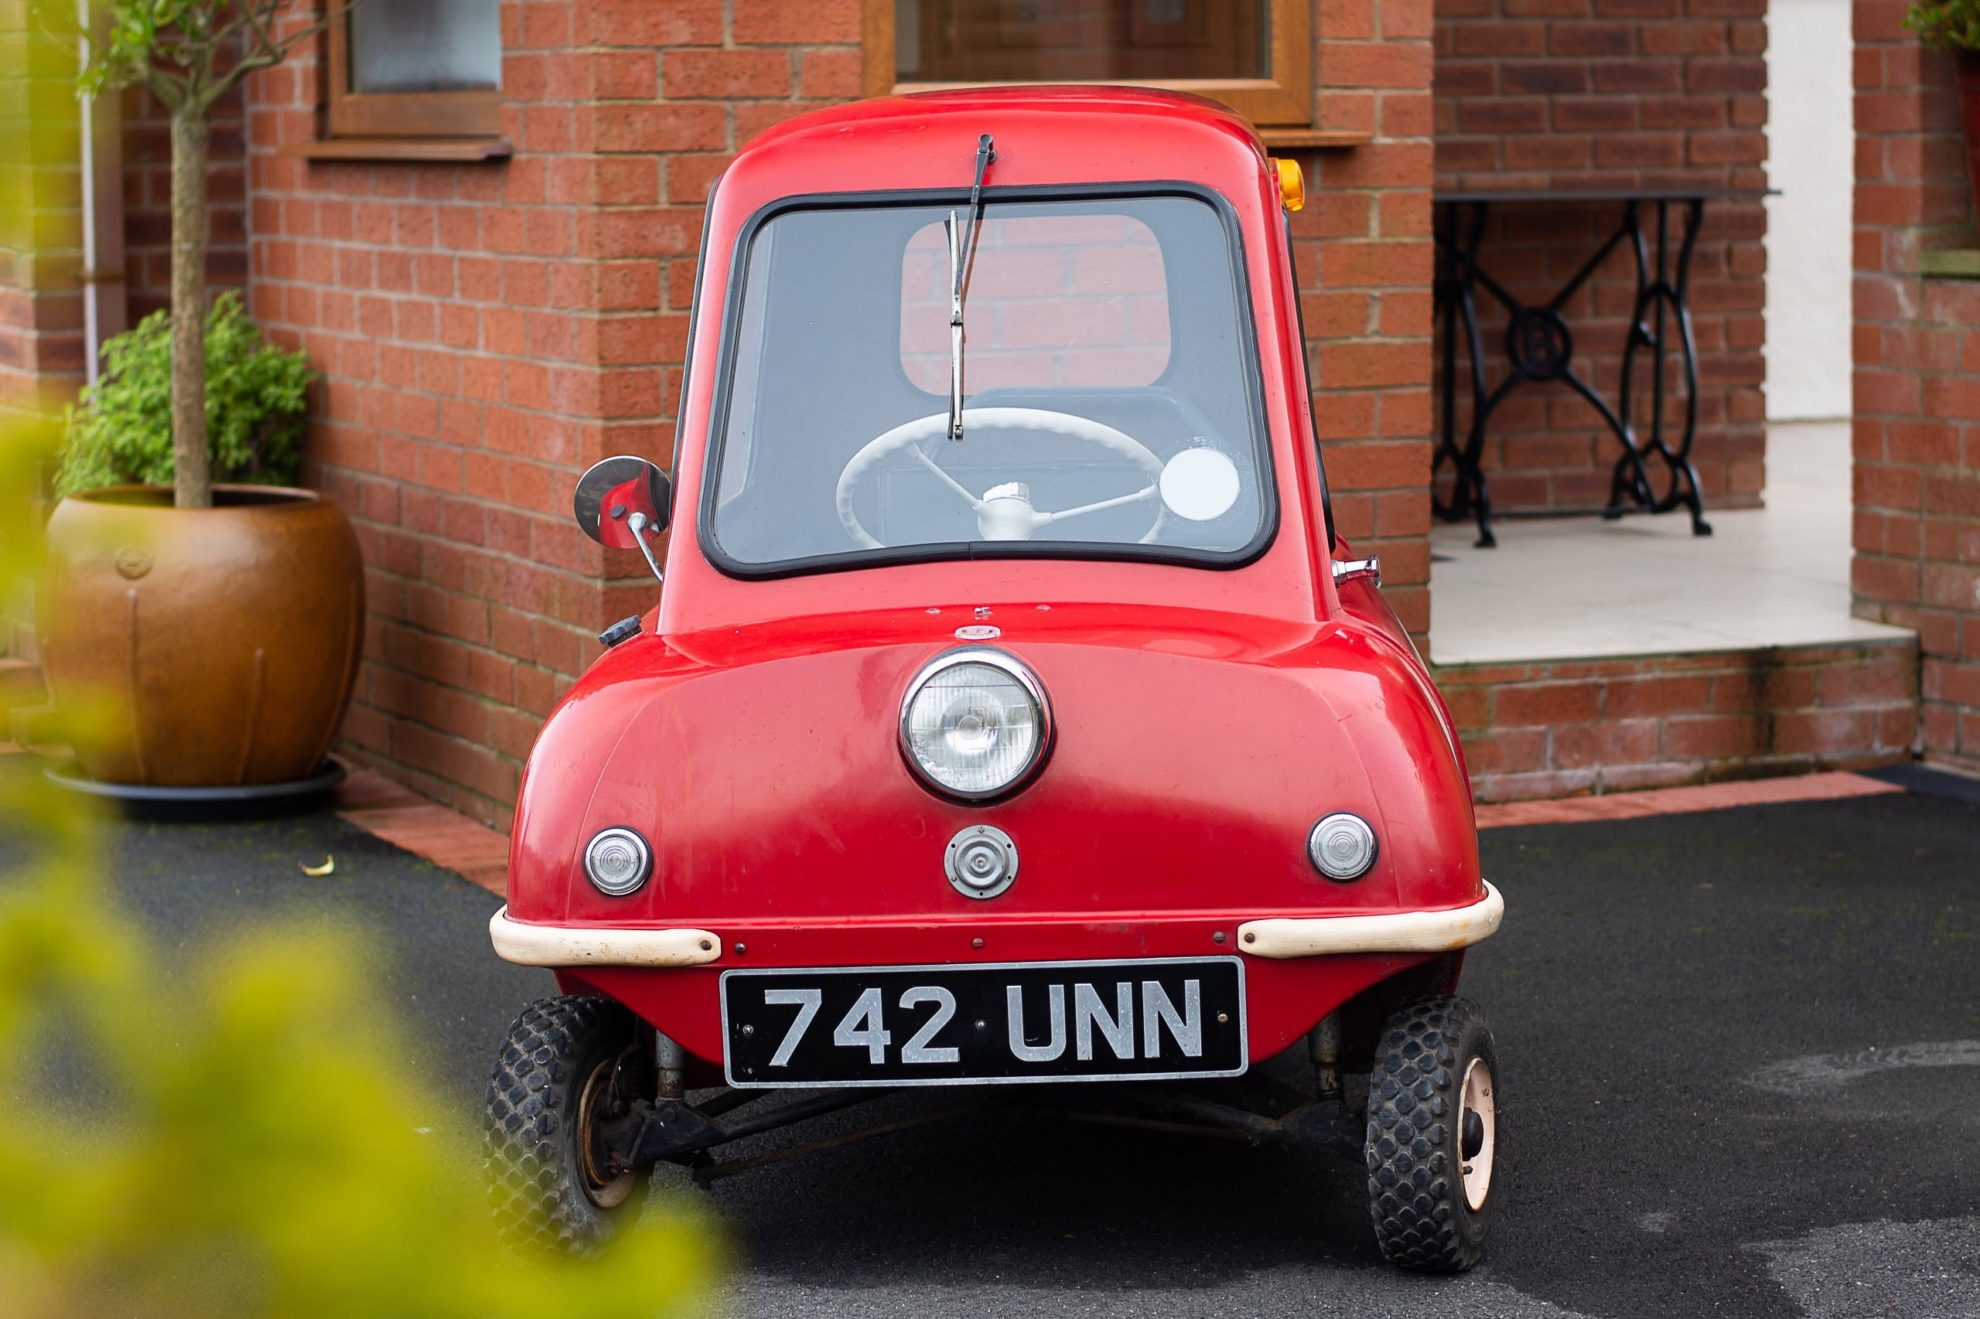

Peel P50 Годы производства	1963—1964, 2010—2013, 2017 — настоящее время
Двигатель 4,2 л. с., это и возьмём за нижнюю планку.   
За верхнюю же, можно взять параметры суперкаров 1100-1200 л. с.

В датасете содержатся автомобили с аномальными значениями мощности двигателя, которые могут искажать анализ данных.   
Удаление таких выбросов с использованием грубого и точного подходов улучшит качество данных и позволит точнее анализировать распределение мощности среди различных типов кузовов.
Проверка:

    Грубый этап удаления аномалий:  
        На этом этапе из датасета будут удалены автомобили с явно ошибочными значениями мощности (менее 4 л.с. или более 1150 л.с.).   
        Эти значения выбраны на основе подтвержденных данных о минимальной и максимальной мощности автомобилей.  

    Точный этап удаления выбросов: 
        На этом этапе для каждого типа кузова будут удалены автомобили с мощностью, выходящей за пределы межквартильного размаха (IQR), что уменьшит влияние особо больших выбросов.

In [ ]:
# Грубый этап удаления аномалий
initial_len = len(df)
df = df[(df['power'] >= 4) & (df['power'] <= 1150)].copy()  # Используем .copy() для явного создания нового DataFrame
removed_gross_outliers = initial_len - len(df)
print(f'На грубом этапе из датасета удалено {removed_gross_outliers} авто.')

# Визуализация после грубого этапа
sns.set(rc={'figure.figsize': (16, 8)})
sns.set_theme(style="darkgrid", palette="muted")
sns.boxplot(data=df, x='vehicle_type', y='power')
plt.title('Распределение мощности двигателя среди разных типов кузова автомобиля (грубый этап)')
plt.ylabel('Мощность двигателя, л.с.')
plt.xlabel('Типы кузова')
plt.show()

# Точный этап удаления выбросов
removed_exact_outliers = 0
for body_type in df['vehicle_type'].unique():
    Q1, Q3 = df.loc[df['vehicle_type'] == body_type, 'power'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    condition = ((df['vehicle_type'] == body_type) &
                 ((df['power'] < (Q1 - 1.5 * IQR)) |
                  (df['power'] > (Q3 + 1.5 * IQR))))
    delete_index = df[condition].index
    removed_exact_outliers += len(delete_index)
    df = df.drop(delete_index).copy() # Используем .drop() с явным созданием нового DataFrame
    df.name = 'Автопродажи'

print(f'На точном этапе из датасета удалено {removed_exact_outliers} авто.')

# Визуализация после точного этапа
sns.boxplot(data=df, x='vehicle_type', y='power')
plt.title('Распределение мощности двигателя среди разных типов кузова автомобиля (точный этап)')
plt.ylabel('Мощность двигателя, л.с.')
plt.xlabel('Типы кузова')
plt.show()

# Итоговое количество удаленных выбросов
total_removed_outliers = removed_gross_outliers + removed_exact_outliers
print(f'Всего из датасета удалено {total_removed_outliers} авто на обоих этапах.')

In [ ]:
# Построение гистограммы
plt.figure(figsize=(18, 8))
df['power'].plot(kind='hist', bins=100, grid=True, legend=False, title='График распределения количества автомобилей по их мощности')
plt.ylabel('Количество автомобилей, шт.')
plt.xlabel('Мощность авто')
plt.show()

# Топ 10 максимальных значений мощности
top_10_max_power = df['power'].nlargest(10)
print("Топ 10 максимальных значений мощности:")
print(top_10_max_power)

# Топ 5 минимальных значений мощности
top_5_min_power = df['power'].nsmallest(5)
print("Топ 5 минимальных значений мощности:")
print(top_5_min_power)

**Выводы по распределению мощности**
Гистограмма, которая была предоставлена, показывает распределение количества автомобилей в зависимости от их мощности. Видно, что:

    Большинство автомобилей сосредоточено в диапазоне 50-200 л.с.:
        Наибольшее количество автомобилей имеет мощность около 90-100 л.с. и около 150 л.с.
        Меньшее количество автомобилей имеет мощность в районе 200-300 л.с.

    Мощности, выходящие за пределы 200 л.с., являются редкими:
        Есть несколько пик на гистограмме в диапазоне 200-300 л.с., но они гораздо меньше по сравнению с основными диапазонами 50-200 л.с.

**Топ 10 максимальных значений мощности**

Максимальные значения мощности варьируются от 300 до 301 л.с., что показывает, что на рынке присутствует ограниченное количество автомобилей с такими высокими значениями мощности.

**Топ 5 минимальных значений мощности**

Минимальные значения мощности варьируются от 8 до 14 л.с., что показывает, что существует несколько автомобилей с крайне низкими значениями мощности, которые могут быть либо очень старыми моделями, либо специализированными транспортными средствами.

**Заключение**

На основании вышеизложенного можно сделать вывод, что большинство автомобилей сконцентрированы в диапазоне мощности от 50 до 200 л.с., и крайне мощные автомобили (более 300 л.с.) или очень слабые автомобили (менее 15 л.с.) встречаются редко. Используя метод межквартильного размаха (IQR), мы смогли удалить выбросы и улучшить качество анализа распределения мощности автомобилей.

In [ ]:
# График распределения пробега автомобилей
kilometer_distribution = df['kilometer'].value_counts().sort_index().to_frame().reset_index()
kilometer_distribution.columns = ['index', 'kilometer']  # Убедись, что столбцы называются правильно

kilometer_distribution.plot(style='o-', x='index', y='kilometer', grid=True, figsize=(18, 8), legend=False,
                            title='График пробега автомобилей на сайте')
plt.ylabel('Количество автомобилей (объявлений)')
plt.xlabel('Общий пробег автомобиля, км.')
plt.show()

# График распределения стоимости автомобилей
df['price'].plot(kind='hist', bins=50, grid=True, figsize=(18, 8), legend=False,
                 title='График распределения количества автомобилей от их стоимости')
plt.ylabel('Количество автомобилей, шт.')
plt.xlabel('Стоимость авто')
plt.show();

**Вывод на основании графиков**
1. График пробега автомобилей на сайте

На графике пробега видно, что большая часть автомобилей имеет пробег около 150,000 км. График показывает резкое увеличение количества объявлений по мере увеличения пробега автомобилей. Это указывает на то, что большинство автомобилей, выставленных на продажу, имеют значительный пробег, что может свидетельствовать о том, что машины находятся в эксплуатации долгое время.  

2. График распределения количества автомобилей от их стоимости

На втором графике можно наблюдать, что большинство автомобилей имеют стоимость до 4,000. Далее количество автомобилей постепенно уменьшается с увеличением стоимости.

In [ ]:
# Проверка распределения и выбросов для 'price'
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Распределение цен автомобилей')
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'])
plt.title('Боксплот для цен автомобилей')
plt.xlabel('Цена')

plt.show();

# Проверка распределения и выбросов для 'kilometer'
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(df['kilometer'], bins=50, kde=True)
plt.title('Распределение пробега автомобилей')
plt.xlabel('Пробег, км')
plt.ylabel('Количество автомобилей')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['kilometer'])
plt.title('Боксплот для пробега автомобилей')
plt.xlabel('Пробег, км')

plt.show();


**Выводы по распределению цен и пробега автомобилей**

Цены автомобилей

    Гистограмма распределения цен:
        Большинство автомобилей сконцентрировано в диапазоне цен до 10,000.
        Наблюдается значительное уменьшение количества автомобилей с увеличением цены.
        Максимальное количество объявлений приходится на автомобили в районе 2,500.

    Боксплот для цен:
        Большинство данных расположено в пределах от около 0 до 10,000.
        Есть значительное количество выбросов выше верхнего уса, которые представляют собой автомобили с ценой свыше 15,000.
        Несмотря на наличие выбросов, их количество незначительно по сравнению с основной массой данных.

Пробег автомобилей

    Гистограмма распределения пробега:
        Большинство автомобилей имеют пробег до 150,000 км.
        Наблюдается резкий скачок количества автомобилей с пробегом около 150,000 км.

    Боксплот для пробега:
        Большинство данных расположено в пределах от 0 до 150,000 км.
        Есть выбросы, представляющие автомобили с пробегом менее 100,000 км.

**Имеет ли смысл удалять данные, выходящие за боксплот?**

Удаление данных, выходящих за пределы боксплота (выбросов), имеет смысл в следующих случаях:

    Если выбросы представляют собой ошибочные данные: Например, неверно указанные цены или пробег.
    Если выбросы могут исказить результаты анализа: Для некоторых моделей машинного обучения наличие сильных выбросов может снизить точность предсказаний.

Однако, стоит учитывать:

    Цены автомобилей:
        Удаление автомобилей с ценами выше 15,000 может привести к потере информации о дорогих автомобилях, которые хоть и встречаются реже, но могут быть важны для анализа премиум-сегмента.
        Если выбросы не являются ошибочными данными, лучше их не удалять, а использовать методы, устойчивые к выбросам.

    Пробег автомобилей:
        Удаление автомобилей с пробегом менее 100,000 км может привести к потере информации о автомобилях с малым пробегом.
        Если выбросы не являются ошибочными данными, то лучше их оставить.

Заключение

Удаление данных, выходящих за пределы боксплота, имеет смысл только в том случае, если это действительно ошибочные или искажающие данные. В случае, если данные корректны, лучше их оставить для более полного анализа, возможно, применив методы, устойчивые к выбросам.

P.S.
Исходя из анализа почтового индекса объявлений, они относяться к Германии. Есть предположение, что объявления с ценой 0 евро, скорее всего, относятся к категории "Машина в дар", что может помешать точности модели. Исходя из сравнения с аналогичными  объявлениями за 2016 год, было определено минимальное значение цены в 100 евро. Поэтому решено удалить все объявления с ценой  ниже 100 евро.

![image.png](attachment:image.png)

In [ ]:
# Сохранение первоначального количества строк
numb = len(df)

# Фильтрация DataFrame и подсчет удаленных строк 
df = df[df['price'] >= 100]
numd = numb - len(df)
df.name = 'Автопродажи'

# Вывод количества удаленных строк
print(f'Количество удаленных строк: {numd}')

In [ ]:
# График распределения пробега автомобилей
kilometer_distribution = df['kilometer'].value_counts().to_frame().reset_index()
kilometer_distribution.columns = ['kilometer', 'count']  # Переименовываем столбцы для удобства

# Сортируем по пробегу (в этом случае, 'kilometer' — это столбец с пробегом)
kilometer_distribution = kilometer_distribution.sort_values(by='kilometer')

# Построение графика
kilometer_distribution.plot(style='o-', x='kilometer', y='count', grid=True, figsize=(18, 8), legend=False,
                            title='График пробега автомобилей на сайте')
plt.ylabel('Количество автомобилей (объявлений)')
plt.xlabel('Общий пробег автомобиля, км.')
plt.show()

# График распределения стоимости автомобилей
df['price'].plot(kind='hist', bins=50, grid=True, figsize=(18, 8), legend=False,
                 title='График распределения количества автомобилей от их стоимости')
plt.ylabel('Количество автомобилей, шт.')
plt.xlabel('Стоимость авто')
plt.show();

In [ ]:
full_info(df)

In [ ]:
# Удаление дубликатов
df = df.drop_duplicates()
df.name = 'Автопродажи'

In [ ]:
full_info(df)

Расчитаем количество дней от создания анкеты до момента скачивания.
Количество дней существования объявления может быть важным фактором для модели предсказания по нескольким причинам:

-    Актуальность информации:
        Объявления, которые находятся на сайте долгое время, могут содержать устаревшую информацию или более низкую вероятность продаж, так как они могли быть неактуальны.
        С другой стороны, свежие объявления могут содержать более актуальную информацию, что делает их более привлекательными для покупателей.

-    Влияние на цену:
        Длительность существования объявления может влиять на цену. Например, объявления, которые находятся на сайте долгое время, могут показывать тенденцию к снижению цены, чтобы привлечь покупателей.

-    Пользовательский интерес:
        Количество дней существования объявления может отражать уровень интереса к нему. Если объявление долго на сайте, возможно, оно не привлекло достаточного внимания, что может быть полезной информацией для модели при оценке привлекательности других объявлений.

-    Показатель востребованности:
        Время существования объявления может указывать на популярность и востребованность конкретной модели автомобиля. Например, если объявления определенной марки или модели остаются актуальными дольше, это может указывать на низкий спрос на этот автомобиль.

-    Анализ рыночной динамики:
        Количество дней существования объявления может помочь в анализе рыночных тенденций. Например, в определенные периоды может быть больше активности на рынке, что приведет к сокращению времени существования объявлений.

In [ ]:
# Вычисление количества дней с момента создания объявления
df['days'] = (df['date_crawled'].max() - df['date_created']).dt.days

# Распределение количества дней
days_distribution = df['days'].value_counts().to_frame().reset_index()
days_distribution.columns = ['days_on_site', 'num_ads']  # Переименовываем столбцы

# Сортируем по 'days_on_site'
days_distribution = days_distribution.sort_values(by='days_on_site')

# Построение графика
days_distribution.plot(x='days_on_site', y='num_ads', style='o-', grid=True, figsize=(16, 6), legend=False, xlim=(0, 40),
                       title='Срок публикации объявлений на сайте',
                       ylabel='Количество объявлений',
                       xlabel='Количество дней на сайте')

plt.show();

Из графика видно, что большинство объявлений действительны не более 35 дней; все автомобили, срок продажи которых превышает этот период, скорее всего, уже проданы. Конечно, существуют редкие исключения с более продолжительным сроком продажи, однако такие случаи не являются массовыми и будут исключены из дальнейшего анализа.

In [ ]:
# Удаление анкет живущих больше 35 дней
print(f'Из датасета удалено {len(df.query("days > 35"))} автомобилей.')
df = df.query('days <= 35')
df.name = 'Автопродажи'

In [ ]:
full_info(df)

**Подведем итоги:**

- Изначальное количество записей: 354,369
- Удалены аномальные значения.
- Удалено дубликатов, строк со странными датами и тестового периода: 16.12% (оставлено 297,235)
- После восстановления пропущенных значений и удаления некорректных строк: 267,516 (удалено 10% от 297,235)
- После всех корректировок осталось: 240,633 записей, что составляет 67.90% от изначального количества.

На этом процесс предобработки считаю завершенным, хотя возможно осталось "Много" незамеченных моментов.
Осталось удалить столбцы которые не будем использовать в работе, а именно date_crawled, date_created, number_of_pictures, last_seen. 

In [ ]:
# Удаление ненужных столбцов
df.drop(columns=['date_crawled', 'date_created', 'number_of_pictures', 'last_seen'], inplace=True)

# Сброс индексов
df.reset_index(drop=True, inplace=True)

# Вывод первых строк для проверки
print(df.head())

## Обучение моделей

**Обучение моделей:**

-    Выделение признаков и целевой переменной.
-    Разделение данных на тренировочную, валидационную и тестовую выборки.
-    Определение категориальных и числовых признаков.
-    Создание предобработчика данных с помощью ColumnTransformer.
-    Создание пайплайнов для каждой модели.
-    Обучение и сохранение моделей в словаре trained_models.

In [ ]:
# Выделение признаков и целевой переменной
target = df['price']
features = df.drop(['price'], axis=1)

# Разделение данных на тренировочную, валидационную и тестовую выборки
X_train, X_other, y_train, y_other = train_test_split(features, target, train_size=0.60, random_state=rnd_state)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size=0.50, random_state=rnd_state)

In [ ]:
# Категориальные и числовые признаки
category = ['brand', 'model', 'vehicle_type', 'gearbox', 'fuel_type', 'repaired']
numeric = ['power', 'kilometer', 'registration_year', 'registration_month', 'postal_code', 'days']

# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop='first'), category)
    ]
)

In [ ]:
# Создание пайплайнов для моделей
models = {
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'RandomForestRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=rnd_state))
    ]),
    'GradientBoostingRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=rnd_state))
    ]),
    'CatBoostRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(verbose=0, random_state=rnd_state))
    ])
}

In [ ]:
%%time
# Обучение и сохранение моделей
trained_models = {}
train_times = {}
for model_name, model_pipeline in models.items():
    start_time = time.time()
    model_pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    trained_models[model_name] = model_pipeline
    train_times[model_name] = train_time
    print(f'{model_name} обучена за {train_time:.2f} секунд')

print("Обучение моделей завершено.")

## Анализ моделей

**Анализ моделей:**

-    Определение функции для оценки моделей с использованием метрики RMSE.
-    Оценка всех обученных моделей на валидационной выборке.
-    Определение лучшей модели на валидационной выборке.
-    Оценка лучшей модели на тестовой выборке.

In [ ]:
# Создание функции для оценки моделей
def evaluate_model(model, X_valid, y_valid):
    start_time = time.time()
    y_pred = model.predict(X_valid)
    prediction_time = time.time() - start_time
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    return rmse, prediction_time

In [ ]:
%%time
# Оценка моделей
results = {}
prediction_times = {}

for model_name, model_pipeline in trained_models.items():
    rmse, prediction_time = evaluate_model(model_pipeline, X_valid, y_valid)
    results[model_name] = rmse
    prediction_times[model_name] = prediction_time
    print(f'{model_name}: RMSE = {rmse:.2f}, Время предсказания = {prediction_time:.4f} секунд')

In [ ]:
%%time
# Проверка на тестовой выборке
best_model_name = min(results, key=results.get)
best_model = trained_models[best_model_name]
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Лучшая модель на тестовом наборе: {best_model_name} с RMSE = {test_rmse:.2f}')

In [ ]:
# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График качества предсказаний (RMSE)
axes[0].bar(results.keys(), results.values(), color='skyblue')
axes[0].set_title('Качество предсказаний моделей (RMSE)')
axes[0].set_xlabel('Модели')
axes[0].set_ylabel('RMSE')
axes[0].axhline(y=2500, color='r', linestyle='--', label='RMSE < 2500')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# График времени обучения
axes[1].bar(train_times.keys(), train_times.values(), color='lightgreen')
axes[1].set_title('Время обучения моделей')
axes[1].set_xlabel('Модели')
axes[1].set_ylabel('Время (сек)')
axes[1].tick_params(axis='x', rotation=45)

# График времени предсказаний
axes[2].bar(prediction_times.keys(), prediction_times.values(), color='lightcoral')
axes[2].set_title('Время предсказания моделей')
axes[2].set_xlabel('Модели')
axes[2].set_ylabel('Время (сек)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show();

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей